# A Random Walk based Trust Ranking in Distributed Systems
-----------
-----------
![](https://d1rkab7tlqy5f1.cloudfront.net/Websections/TU%20Delft%20Huisstijl/TU_Delft_logo_RGB.png?raw=true)

<center>
Alexander Stannat 
</center>

<center>
07.09.2018
</center>

## Preface


This document is a report written for the course in "Blockchain Engineering" taken at 
Delft University of Technology in 2018. It was written to aid the Blockchain Lab's
research on cooperation in distributed systems. 

In it we discuss the implementation of 
an algorithm to determine the trustworthiness of agents in a peer-to-peer file sharing 
network, called Tribler. 

In this way, we hope to contribute to the lab's long-term goal of achieving a universal
mechanism of generating trust in distributed networks.


## Table of Contents:
1. [Introduction](#Introduction)   
1.1 [Historical Background](#HistoricalBackground)   
1.2 [Trust](#Trust)   
1.3 [Trustchain](#Trustchain)   
1.4 [Problem Description](#ProblemDescription)

2. [Preliminaries](#Preliminaries)   
2.1 [The Model](#TheModel)   
2.2 [Interaction Graphs In Tribler](#InteractionGraphsInTribler)

3. [The Algorithm](#TheAlgorithm)   
3.1 [PageRank](#PageRank)   
3.2 [Monte Carlo Methods for PageRank approximation](#MonteCarlo)

4. [Implementation](#Implementation)   
4.1 [Unit Testing](#UnitTesting)   
4.2 [Convergence Testing](#ConvergenceTesting)   
4.3 [Sybil Resistance](#SybilResistance)

5. [Application to the Tribler Network](#TriblerApplication)   
5.1 [Generating the Graph](#GraphGeneration)   
5.2 [Computing PageRank](#TriblerPageRanks)   
5.3 [Incremental Updates](#IncrementalUpdates)

6. [Conclusion](#Conclusion)

7. [Future Work](#FutureWork)

## Introduction <a id="Introduction"></a>
### Historical Background <a id="HistoricalBackground"></a>

With the ever-growing expansion and widespread acceptance of the internet, the field of research in distributed systems 
is gaining evermore importance. In its simplest definition, a distributed system is a group of different processors working together on a common task. These processors have a shared state, operate concurrently and can fail independently. The primary 
advantages of a distributed system over a centralized system are scalability, fault-tolerance and lower latency. There are however some drawbacks to the decentralized nature of these networks. The most notable being resource-management.  

A particular example of distributed systems are peer-to-peer networks, also known as P2P networks. A peer-to-peer network allows computers to communicate without the need for a central server. Peer-to-peer file sharing refers to the distribution of digital media over a P2P network, in which the files are located on individuals' computers and shared with other members of the network. P2P software was the piracy method of choice in the early 2000s with software programs such as LimeWire, Gnutella and the BitTorrent client being the most prominent sites. A Supreme Court decision in 2005 led to the closure of many of these sites for illegally sharing copyrighted material, mostly music.​

In a peer-to-peer file sharing network agents up- and download files over the network to one another in a cooperative manner, whereby
an agent that is holding a file (or at least a part of it) can offer it to other agents that require it, through actions called seeding and leeching. Seeders are those who offer upload bandwidth while leechers are the agents that download the data. While these types of systems have many advantages over the standard client-server model, they do have one fundamental problem: users have an obvious incentive to download, i.e. to leech, but no inherent incentive to seed. This results in behavior called lazy freeriding.

In order to avert freeriding and to incentivize its users to participate in the network reciprocally, early file sharing networks such as the BitTorrent protocol employ a mechanism called tit-for-tat. Tit-for-tat is a highly effective strategy in game theory for the iterated prisoner's dilemma, in which an agent cooperates first and then replicates it's contender's previous actions. In practice, this works as follows. Peers in the BitTorrent network have a limited number of upload slots to allocate. An agent will begin by exchanging upload bandwidth for download bandwidth with a number of its peers. If one of these peers turns out to be a leecher, i.e. does not reciprocate, it will be *choked*. This means the agent will discontinue it's cooperation and assign the corresponding upload slot to another randomly chosen peer in a procedure known as *optimistic unchoking*. 

However, we find that defecting is the dominant strategy in the Prisoner's dilemma. The agents' inability to coordinate and build expectations of their counterparts ensures that everyone will be worse of than if they had collaborated. This is also known as the tragedy of the commons. Agents do not keep a memory about their peer's reliability which enables such lazy freeriding and other types of uncooperative behavior. There is no mechanism with which peers can be evaluated based on their previous reliability or trustworthiness as nodes in the network and hence every new transaction entails the risk of the partner node defecting. This leads us to the main research question, the TU Delft's Blockchain Lab focuses their study on: Is it possible to incorporate a digital counterpart to trust in a distributed network with no central authority? 

### Trust <a id="Trust"></a> 
Trust is a rather abstract concept which is oftentimes understood more on an intuitive level as opposed to a clear-cut definition. Thus there are many different possible definitions of trust. In this project we chose to adopt one of the definitions of trust given in Vandenheuvel's [Mathematics of Trust](https://github.com/vandenheuvel/mathematics-of-trust). 

*_Definition_*  
Two agents (a *trustor* and a *trustee*) have a trust relationship if the trustor is uncertain about the outcome of the trustee's actions and can only rely on developed expectations. 

Trust is a necessary catalyst for cooperation in networks and there have been many different approaches to facilitating trust relationships in distributed systems. Companies like eBay, Uber or Airbnb utilize reputation systems based on ratings. Agents in these networks leave publicly accessible reviews of eachothers' collaborators after each transaction. These reviews are stored and maintained by a central authority, so that no fraud can take place. Based on these reviews the network generates reputation systems for all nodes. Agents then decide who to interact with based on this reputation, thereby incentivizing cooperative behavior off all participants. 

The TU Delft's Blockchain Lab aims to take this trust system a step further, by removing the central authority that manages the network and its reputation system. In order to gain an understanding of how this is possible we look into the sociological aspects of cooperative networks among people in the real world. [Nowak, Martin A.](http://science.sciencemag.org/content/314/5805/1560) discuss what psychological mechanisms engender cooperative networks in the animal kingdom, namely kin selection, direct reciprocity, indirect reciprocity, network reciprocity, and group selection. DBL is researching the possibility of incorporating a mechanism of indirect reciprocity into their p2p file sharing network called tribler.

### Trustchain <a id="Trustchain"></a> 

In order to build such a digital trust mechanism into a perfectly decentralized network, a distributed storage space, or ledger, is required. The tools most commonly used for this purpose are Blockchains. Blockchains are data structures that utilize cryptographic primitives such as public-key cryptography to maintain a consensus on data, stored on many different processors in a distributed system. Transactions between agents in the network are grouped in blocks which, in turn, are interlinked by a hash chain. Blocks are created by "miners", nodes in the network that collect and group transactions. In order to obtain a block, the miner needs to solve a crpytographic hash puzzle through a protocol known as proof-of-work. When conflicting states occur, the chain forks, and miners contribute to the chain they believe is the valid one. At some point, one chain will overtake the other and all miners transition to that chain. The resulting chain of blocks is therefore immutable as well as fraud-proof.

<img src="https://media2.giphy.com/media/3oKIP7E6cfooMrm9IQ/source.gif" width="200" height="200" />
 
Blockchains however have one major drawback that the classical client-server model does not have. Consensus is maintained by miners receiving information about all transactions that have transpired in the network. As the network grows, the risk of transaction broadcasts not reaching certain miners increases, which makes maintaining a global consensus more and more difficult. This fundamentally limits the scalability of such blockchain based networks. In pursuing a more scalable alternative, the blockchain lab has developed their own type of distributed ledger, called *TrustChain*. TrustChain is what's known as a fourth-generation blockchain.

In TrustChain, all network participants maintain their own chain of transactions. There is no mining and no global consensus. The TrustChain maintains records of all interactions between peers in the network, in respective blocks. Each block contains data about an individual transaction between two peers, such as the respective up-and download values, the peers' public keys and signatures as well as block sequence numbers and respective hashes. Blocks are linked to one another through hash pointers. Each block is thereby connected to two preceding and two succeeding blocks, i.e. each block is contained in the chains of both transaction partners. This results in many different chains, each corresponding to a single agent's transaction history.

![](https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcS6Cf1tDXgQqnS7Sf3bdHkggx2OmMzHm_cwfFWB8ZyOg8zPtN8F)

When two agents interact with one another, they make their respective chains visible to each other and may even store information about each other's chains as well. This structure is strongly scalable, both in the number of agents in the network as well as in the number of transactions per agent. Moreover, the trustchain does not maintain a global consensus. This means that double-spends are not actually prevented, as they are in traditional blockchains. However, they are made detectable and can subsequently be penalized through peer rejection or even by banning dishonest nodes from the network. Thereby fraudulent activity is not actually prevented, but strongly disincentivized.

### Problem Description <a id="ProblemDescription"></a>

As discussed in [Historical Background](#HistoricalBackground) the long standing issue of tribler is digitizing a method for evaluating the trustworthiness, or reputation, of agents in a network. Such a mechanism is meant to deter lazy freeriders, i.e. agents that purposefully contribute no or very little resources to the network, but at the same time utilize the network for their own benefit. 

There have been many different approaches to this problem, however a viable and accurate solution has yet to be found. The first reputation system introduced in Tribler was *BarterCast*. BarterCast was based on the voluntary reports of agents about their own transactions. However, an inherent problem with the BarterCast system is the issue of deliberate misreporting about transactions, by agents that have made overall negative contributions to the network. After BarterCast, another accounting mechanism was introduced: DropEdge, which is an implementation of BarterCast on a subset of the graph, ignoring all nodes that are interested in receiving some data. 

In this project we aim to implement a mechanism which enables the ranking of nodes in the tribler network based on their respective reputability. Reputatbility should be a measure of the impact a node has on the network. This means that nodes with a low or negative net contribution made to the network should be ranked lower than more altruistic nodes. When a node is looking to query an overlay for a file to download, it will generate this ranking and determine which agent in the swarm it should engage with to maximize the likelihood of a successful transaction and a subsequent reciprocal relationship. We present a number of requirements that this trust mechanism should satisfy. 

1. Personalisation  
Trust is personal. Two different agents in the network may have a completely different perception of their neighbours' trustworthiness. This means that an algorithm computing a trust ranking of nodes must depend on the node from whose perspective the trustworthiness is determined.  

2. Locality  
[Piatek, Michael, et al.](https://homes.cs.washington.edu/%7Earvind/papers/onehop.pdf) observe that in the BitTorrent network most peers share a one hop relationship. Therefore we restrict the amount of indirection in between contributing and reciprocating peers. This makes sense in a social context as well. A node may trust one of its peers, and by transitivity of trust, it will also trust this peer's trustees, although less. A third or fourth hop will reduce the transitive trust to a minimum.

3. Incrementality  
The underlying graph structure of the network continually evolves as transactions take place and new blocks are added to agents' trustchains. Trust rankings therefore develop continuously as well. Recomputing these trust rankings from scratch is prohibitively expensive. We require our algorithm to be able to update the trust rankings incrementally as more information arrives over time. We update the trust rankings in batches, either in time intervals, or by the amount of information that has become available. 

A very popular existing algorithm that is used to rank the importance of pages on the world wide web is Google's pagerank algorithm. In the context of the internet, we find that the importance ranking by google is an equivalent concept to our idea of trustworthiness in p2p networks. Given the resemblance of the graph structures of both the web and the tribler network, the use of the pagerank algorithm for the assessment of agents' trustworthiness suggests itself. 

## Preliminaries <a id="Preliminaries"></a>

### The Model <a id="TheModel"></a>

In order for us to model the Tribler network in a graph structure we look into the number of different models defined in [Otte et al](https://ac.els-cdn.com/S0167739X17318988/1-s2.0-S0167739X17318988-main.pdf?_tid=464512ca-e4b2-48e7-a94e-876bb2c9888d&acdnat=1537298227_b0ac117d8807479280cad43d09ef70bb). There, the concept of an ordered interaction model is introduced, which we will briefly recap. 

*Definition* (Ordered Interaction Model)    
Define an ordered interaction model as $M=\left\langle P,I,a,\omega\right\rangle$, which is uniquely determined by the following 4 sets:
* $P$: a finite set of agents
* $I$, a finite set of interactions
* $a:I\rightarrow{}P\times{}P$, a function mapping each interaction to the participants involved 
* $\omega:I\times{}P\rightarrow\mathbb{R}_{\geq 0}$, a function mapping an interaction and an agent to the contribution made by the agent in that interaction.
For any $p\notin{}a(i)$ it must hold $\omega(i,p)=0$. Note that $\omega$ also allows for negative values, in case of leeching.
For any agent the interactions involving this agent must be completely ordered temporally.

From this mathematical framework we now derive the graph structure on which we will instantiate the trust mechanism.

*Definition* (Interaction Graph)   
Given an ordered interaction model $M=\left\langle P,I,a,\omega\right\rangle$, we define an interaction graph $G = (\mathcal{V}, \mathcal{E})$ by the sets
* $\mathcal{V}=\left\lbrace v_p | p\in{}P\right\rbrace$
* $\mathcal{E}=\left\lbrace (v_p,v_q) | \exists i\in I, a(i)=(p,q) \right\rbrace$

Here, the network is given by a directed graph $(\mathcal{V}, \mathcal{E})$ with a set $\mathcal{V}$ of $N$ vertices or nodes and a set $\mathcal{E}$ of edges. The vertices correspond to the agents, or peers, in the network. The edges reflect interactions between agents. 

The edge weights for an edge $(v_p,v_q)\in\mathcal{E}$ in this graph are determined by 
$$\omega((v_p, v_q)):=\sum_{\left\lbrace i\in I:a(i)=(p,q)\right\rbrace}\omega(i,p)$$

Edges are unidirectional and weighted, whereby the weight $\omega(a,b)$ of an edge connecting vertices $a$ and $b$ corresponds to the net data flow between two peers, i.e. the difference between up- and downloaded data. Two vertices are only ever connected by at most one directed edge. The direction of the edge is determined by the absolute value of the net data flow in between two nodes, i.e. if node $a$ has a surplus of uploaded data over node $b$ then the edge connecting the two will point towards $a$. With each transaction, edges are either added to the graph or modified in their weight. This means that, if for instance the absolute difference of up- and downloaded data changes, such that the node that had previously seeded more than leeched, now finds itself in "debt", then the direction of the edge is changed. An example of an interaction graph is given below, with agents P,Q and R. 

<img src="https://raw.githubusercontent.com/alexander-stannat/Incremental-Pagerank2/master/Interaction%20Graph.PNG" width="500" height="500" />

### Interaction Graphs in Tribler <a id="InteractionGraphsInTribler"></a>
As we have already discussed in [TrustChain](#Trustchain), interactions in the Tribler network are recorded in a distibuted storage structure called the TrustChain. In the TrustChain, every block corresponds to an interaction. We can visualize the trustchain with what [Otte et al.](https://ac.els-cdn.com/S0167739X17318988/1-s2.0-S0167739X17318988-main.pdf?_tid=464512ca-e4b2-48e7-a94e-876bb2c9888d&acdnat=1537298227_b0ac117d8807479280cad43d09ef70bb) refers to as an ordered interaction graph, were every node corresponds to a block in the trustchain and the edges represent the hash pointers in the chain. However, in order for us to obtain a trust mechanism for agents in the tribler network by running the pagerank algorithm, we need to transform our trustchain graph into an interaction graph. In order to do this, we take a closer look at the blocks contained in the tribler blockchain. 

Blocks are tables made up of the following columns:

* type
* tx
* public key
* sequence_number
* link_public_key
* link_sequence_number
* previous_hash
* signature
* block_timestamp
* insert_time
* block_hash

The tx column contains a dictionary of four keys: total_up, total_down, up and down. These values correspond to the data shared between the two nodes involved in the transaction. The total_up and total_down values represent the accumulated data flow in between the two nodes over the entire time. The public_key value represents the public key of the requester of the transaction while the link_sequence number is that of the responder. The sequence number is the numbering of the blocks in the chain of the requester and the link_sequence_number then represents the numbering of the block in the responder's chain. 

In the interaction model, every node in the graph corresponds to a public key in the network. We retrieve all nodes in the graph from the public_key and link_public_key fields of all trustchain blocks. We then acquire the edges from the up and down values of the "tx" dictionary. We aggregate these over all transactions involving the two agents and then determine the weight and subsequently the direction of the edge in between two nodes. This is repeated for all pairs of nodes until we have generated an entire interaction graph. We did this in a class labelled "Open_Database2", given below.


In [3]:
"""
The code below opens the multi-chain database and generates a graph of nodes corresponding to peers in the network
and edges representing the flow of data in between peers
"""
import sqlite3
import networkx as nx
from Encode import decode
import copy


class GraphReduction2(object):
    """
    Class to open the multichain data set file consisting of tables, comprising the columns: type,
    tx (a dictionary containing the amount of up- and downloaded data), public_key, sequence_number_requester,
    public key responder (link public key), link sequence number, previous hash, signature, block timestamp,
    insert time and block hash

    A directed graph is then generated with nodes corresponding to the public_key of peers in the network and edges
    representing interactions between individual peers. The weight of an edge connecting to peers is determined by
    the net flow of data in between these peers. The direction of an edge is determined by the sign of the net flow,
    i.e. if a has transferred 3GB to b and b has transferred 1GB to a, then the graph will have a directed edge from
    a to b of weight 2GB.
    """

    def __init__(self, file_path, file_name):
        """
        Initializes Graph Reduction Class
        :param file_path: Path of database file
        :param file_name: Name of database file
        """
        self.file_path = file_path
        self.file_name = file_name
        self.graph = nx.DiGraph()
        self.blocks = []
        self.nodes = set()
        self.edges = dict()

    def open_data_set(self):
        """
        Accesses the trustchain data set and opens all rows. Then a graph is generated from all rows with nodes
        corresponding to public keys and edges corresponding to transactions.
        """
        conn = sqlite3.connect(self.file_path + self.file_name + ".db")
        cursor = conn.cursor()
        cursor.execute("""SELECT * FROM blocks""")
        self.blocks = iter(cursor.fetchall())
        for block in self.blocks:
            self.nodes.update([str(block[2]).encode('hex'), str(block[4]).encode('hex')])
            if decode(str(block[1]))[1].keys() == ["down", "total_down", "up", "total_up"]:
                if (str(block[2]).encode('hex'), str(block[4]).encode('hex')) in self.edges.keys():
                    self.edges[(str(block[2]).encode('hex'), str(block[4]).encode('hex'))] += \
                        decode(str(block[1]))[1]["down"] - decode(str(block[1]))[1]["up"]
                    if self.edges[(str(block[2]).encode('hex'), str(block[4]).encode('hex'))] < 0:
                        self.edges[(str(block[4]).encode('hex'), str(block[2]).encode('hex'))] = -\
                            self.edges[(str(block[2]).encode('hex'), str(block[4]).encode('hex'))]
                        del self.edges[(str(block[2]).encode('hex'), str(block[4]).encode('hex'))]

                elif (str(block[4]).encode('hex'), str(block[2]).encode('hex')) in self.edges.keys():
                    self.edges[(str(block[4]).encode('hex'), str(block[2]).encode('hex'))] += \
                        decode(str(block[1]))[1]["up"] - decode(str(block[1]))[1]["down"]
                    if self.edges[(str(block[4]).encode('hex'), str(block[2]).encode('hex'))] < 0:
                        self.edges[(str(block[2]).encode('hex'), str(block[4]).encode('hex'))] = -\
                            self.edges[(str(block[4]).encode('hex'), str(block[2]).encode('hex'))]
                        del self.edges[(str(block[4]).encode('hex'), str(block[2]).encode('hex'))]
                else:
                    if decode(str(block[1]))[1]["down"] - decode(str(block[1]))[1]["up"] >= 0:
                        self.edges[(str(block[2]).encode('hex'), str(block[4]).encode('hex'))] = \
                            decode(str(block[1]))[1]["down"] - decode(str(block[1]))[1]["up"]
                    elif decode(str(block[1]))[1]["down"] - decode(str(block[1]))[1]["up"] < 0:
                        self.edges[(str(block[4]).encode('hex'), str(block[2]).encode('hex'))] = \
                            decode(str(block[1]))[1]["up"] - decode(str(block[1]))[1]["down"]
                    if decode(str(block[1]))[1]["up"] - decode(str(block[1]))[1]["down"] >= 0:
                        self.edges[(str(block[2]).encode('hex'), str(block[4]).encode('hex'))] = \
                            decode(str(block[1]))[1]["up"] - decode(str(block[1]))[1]["down"]
                    elif decode(str(block[1]))[1]["up"] - decode(str(block[1]))[1]["down"] < 0:
                        self.edges[(str(block[4]).encode('hex'), str(block[2]).encode('hex'))] = \
                            decode(str(block[1]))[1]["down"] - decode(str(block[1]))[1]["up"]
        self.nodes = list(self.nodes)
        self.edges = iter(zip(self.edges.keys(), self.edges.values()))
        self.edges = iter(edge[0] + (edge[1],) for edge in self.edges)
        return

    def generate_graph(self):
        self.graph.add_nodes_from(self.nodes)
        self.graph.add_weighted_edges_from(list(self.edges))
        return self.graph



## The Algorithm <a id="TheAlgorithm"></a>
### PageRank <a id="PageRank"></a>

Traditionally, PageRank is computed through a method called the Power Iteration. The Power Iteration is determined in the following way. Let $n$ denote the number of nodes in the network. Define the $n\times{}n$ hyperlink matrix $P$ such that if $i$ is a node with $k$ outgoing edges with respective edge weights $\omega_{ij}$, for $k$ nodes $j$ connected to $i$ then 
$P_{ij}=\frac{\omega_{ij}}{\sum_{l=1}^{k}\omega_{il}}$
and $p_{ij}=0$ if $j$ is not connected to $i$ at all. The entries of P can then be interpreted as the probability of a random walk of the network hopping from node $i$ to node $j$, given that it has reached node $i$. If a page has no outgoing links at all, it is called a dangling node and the transition probability is then spread evenly among all nodes, i.e. $p_{ij}=\frac{1}{n}$.

This can be intrepreted as a *random surfer* on the graph hopping from node to node along the edges and then teleporting to a random node in the graph with some reset probability $c$ at every stop. It will also teleport once it reaches a dangling node. 

Thus, the PageRank is deﬁned as a stationary distribution of a Markov chain whose state space is the set of all nodes, and its transition matrix is given by 
\begin{equation}
\tilde{P} = (1-c)P + c\left(\frac{1}{n}\right)E 
\end{equation} 
where $E$ is a $n\times{}n$ matrix with all values equal to one and $c\in{}(0,1)$ is the reset probability. This matrix is stochastic, aperiodic and irreducible and therefore there exists a unique vector $\pi$ such that 
\begin{equation}
\tilde{P}\pi = \pi,\quad \textrm{with } \pi\underline{1} = 1
\end{equation}
This vector $\pi$ is then called the PageRank vector. The values $\pi_i$ can be interpreted as the probability of a random surfer landing on page $i$ in an infinite random walk of the network. It denotes the importance of nodes in the graph. In our case this importance to the network can also be interpreted as the nodes trustworthiness.

The Power Iteration can be computed in an iterative manner. One begins with $\pi_0(i)=\frac{1}{n}$ for all nodes $i=1,...,n$. The values are then computed iteratively as follows. 
$$
\pi_{k+1}(i) = \frac{1-c}{n} + \sum_{\left\lbrace j\,|\,(j,i)\in\mathcal{E}\right\rbrace}\left(\frac{\pi_k(j)}{outdeg(j)}\right)c
$$

This iteration is finished, once the difference of the consecutive values passes a certain treshold $\varepsilon$, or the number of iterations reaches a certain predetermined upper bound. 

The pagerank values can be personalized to a particular seed node. In that case the pagerank values of all nodes in the network depend on the initial choice of the seed node. They are, so to speak, the pageranks determined from the perspective of the seed node. In that case the transition matrix is given by
$$
\tilde{P} = (1-c)P + c\left(\frac{1}{n}\right)\tilde{E}
$$
whereby $\tilde{E}$ is a matrix of only zeros, with a column of ones at the i-th place, with $i$ being determined by the seed node.

The iterative computation then follows a slightly different formula. For the pagerank of the seed node it is given by
$$
\pi_{k+1}(i) = 1-c + \sum_{\left\lbrace j\,|\,(j,i)\in\mathcal{E}\right\rbrace}\left(\frac{\pi_k(j)}{outdeg(j)}\right)c
$$
and for all other nodes 
$$
\pi_{k+1}(i) = \sum_{\left\lbrace j\,|\,(j,i)\in\mathcal{E}\right\rbrace}\left(\frac{\pi_k(j)}{outdeg(j)}\right)c
$$
### Monte Carlo Methods for PageRank Approximation <a id="MonteCarlo"></a>

[Avrachenkov, Konstantin, et al.](https://epubs.siam.org/doi/abs/10.1137/050643799) observe that the end-point of a random walk of the network that starts from a random page and can be terminated at each step with probability $1-c$, appears to be a sample from the distribution of $\pi$. Thus we find a random walk based algorithm for estimating the pagerank values of a network. By repeating the random walks of the graph many times, an estimate of $\pi_j$ for $j = 1,...,n$ can be given by the number of times a run crosses $j$, divided by the total number of nodes crossed by all random walks. This method for approximating PageRank is known as the Monte Carlo method.

The Monte Carlo method for estimating the PageRank vector has several advantages over the power iteration method. Let's recall the three requirements we defined for the trust algorithm in [Problem Description](#ProblemDescription). Personalization, locality and incrementality. The Monte Carlo algorithm satisfies all three of these requirements and we will show that it provides a good estimation of PageRank after relatively few iterations. 

Monte Carlo algorithms are motivated by the following formula

$$
\pi = \frac{1-c}{n}\underline{1}^T\left[\mathbb{1} - cP\right]^{-1} = \frac{1-c}{n}\underline{1}^{T}\sum_{k=0}^{\infty}c^kP^k
$$

which suggests a simple way of sampling from the PageRank distribution. [Avrachenkov, Konstantin, et al.](https://epubs.siam.org/doi/abs/10.1137/050643799) introduce 5 different algorithms to estimate the personalized pagerank, motivated by the equation above. We chose to implement the fourth algorithm. We run a simple random walk $(X_t)_{t\geq{}0}$, $m$ times starting at the seed node in the network that either stops with probability $c$ at every node reached, or when a dangling node is reached, else it transitions along the edges as determined by matrix $P$. The length of these random walks varies around an average of $\frac{1}{c}$. According to the equation above the nodes reached by these random walks then should approximate the distribution of $\pi$.  Below is a visual representation of this particular Monte Carlo method.

![](https://2.bp.blogspot.com/-nn37hjdFR8E/UzqHsJHfQMI/AAAAAAAABHg/b7_7JjkGmIQ/s1600/g4.gif)

Let $W_{ij}$ be a random variable denoting the number of times the random walk $(X_t)_{t\geq 0}$ reaches node $j$ given that it originated at node $i$. Formally,

$$
\mathbb{P}(W_{ij} = x) = \mathbb{P}\left(\left[\sum_{t=0}^{\infty}\mathbb{1}_{\left\lbrace X_t=j\right\rbrace}\right]=x|X_0=i\right)
$$

Then, the estimator for $\pi$ obtained by this algorithm is given by 

$$
\bar{\pi}_j = \left[\sum_{l=1}^{m}\sum_{i=1}^{n}W^{(l)}_{ij}\right]\left[\sum_{l=1}^{m}\sum_{i,j=1}^{n}W^{(l)}_{ij}\right]^{-1}
$$

where $W^{(l)}$, $l\geq{}1$ are independent random variables of the same distribution as $W_{ij}$. 

Theorem 1 in [Avrachenkov, Konstantin, et al](https://epubs.siam.org/doi/abs/10.1137/050643799) states that the estimator $\bar{\pi}_j$ converges to $\pi_j$ as the number of random walks goes to infinity. Thus $\bar{\pi}$ is a consistent estimator. Additionally it is shown that this particular Monte Carlo method achieves an error of about 1% for the highest 12 nodes. Thus, the deﬁned $\bar{\pi}$'s are accurate approximations of the actual PageRank values $\pi$. [Bahmani, B., Chowdhury, A., & Goel, A.](https://arxiv.org/abs/1006.2880) showed that this estimator is, in fact unbiased and sharply concentrated around its expected value.

### Personalization <a id="Personalization"></a>

Recall the primary idea behind the PageRanks of nodes was for a node seeking to acquire data, to evaluate the peers in its vicinity. There is no central authority which it can query for these values and it cannot necessarily rely on other agents sharing information about their previous transactions with other nodes honestly. Therefore, the node must determine these values by itself. We adjust the Monte Carlo method such that all random walks originate from the same node, i.e. the downloader, also known as the seed node. The PageRanks are then computed analogously, but from the "perspective" of the seed node. The alternative PageRank vector obtained through this method is called *personalized* PageRank. 

### Locality <a id="Locality"></a>
Recall the second requirement we had for this algorithm. Nodes do not query the entire network for data. They direct their focus primarily towards other nodes within their vicinity. This is due to transitive trust declining rapidly over an increasing number of hops through the network. The Monte Carlo algorithm enables exactly this, by applying random walks with relatively high reset probabilities, e.g. values in between 0.2 and 0.5 we find that the PageRanks are more focused around a node's immediate neighbourhood as opposed to weighting all nodes alike. 

### Incremental Computation <a id="IncrementalComputation"></a> 
The tribler network does not stay still. Accounts are made as well as deleted and new transactions transpire continuously. Edges are added and removed or have their weight changed through transactions. Consequently the PageRank values fluctuate and have to be recomputed everytime the graph structure changes. It is simply unsustainable to recompute all random walks from scratch everytime the network is updated. Small alterations made to the graph, such as the addition or deletion of individual nodes and/or edges, are unlikely to impact a significant proportion of random walks in the network. Therefore it's not just not necessary to recompute all random walks everytime the graph changes. 

Only those random walks that pass through an edge or node that has been altered, need to be reviewed. And they only need to be recomputed starting at the last node they reached before they passed the modified region (edge or node). Let's say a node is removed from the network. All random walks that reach a node, the removed node was connected to, are then recomputed starting at the that node. If an edge is removed then all random walks that reach the source node of the removed edge are recomputed starting at the source node. The same goes for when an edge is added. This, of course is an alternative that is computationally far less expensive than a rerun of the entire algorithm everytime an edge is added or removed.

It should be noted here that it is far more common for new edges and nodes to arrive rather than existing edges and nodes to leave the network.

[Bahmani, B., Chowdhury, A., & Goel, A.](https://arxiv.org/abs/1006.2880) proved the following two theorems about the expected amount of additional update work for arriving and disappearing edges. 

*Theorem 1*    
Let $(u_t, v_t)$ be the $t^{th}$ random edge that is added to the graph and let $M_t$ be the random variable that determines the number of random walk segments that subsequently need to be updated. Finally, let $R$ denote the number of random walks and $l_i$ the length of the $i^{th}$ random walk. It then holds
$$
\mathbb{E}[M_t] \leq \sum_{i=1}^{R}l_i\mathbb{E}[\frac{\pi_{u_t}}{outdeg_{u_t}(t)}]
$$
Additionally, it holds 
$$
\mathbb{E}[\frac{\pi_{u_t}}{outdeg_{u_t}(t)}] = \frac{1}{t}
$$
So it is

$$
\mathbb{E}[M_t] \leq \frac{1}{t}\sum_{i=1}^{R}l_i
$$

For each random walk segment that needs to be updated, we compute a random walk from the corresponding source node. Hence, we can expect $\frac{1}{c}$ work per recomputed random walk. Now, we can sum up the expected amount of update work over $m$ edge arrivals and we obtain 

$$
\mathbb{E}[\sum_{t=1}^{m}M_t] \leq \frac{1}{\varepsilon}\sum_{i=1}^{R}l_i \sum_{t=1}^{m}\frac{1}{t}  
$$

Seeing as the harmonic series is bounded from above by the natural logarithm, we finally obtain 

$$
\mathbb{E}[\sum_{t=1}^{m}M_t]\leq\frac{1}{\varepsilon}\sum_{i=1}^{R}l_i \ln{m} \approx \frac{R}{\varepsilon^2}
$$

For the counterpart of edges leaving the graph we have the following result

*Theorem 2*   
For a network with $m$ edges, if a randomly chosen edge leaves the graph, then the expected amount of work necessary to update the walk segments is at most 

$$
\frac{1}{\varepsilon}\sum_{i=1}^{R}l_i\approx\frac{R}{\varepsilon^2}
$$

From this we learn that the cost to keep the PageRank approximations updated is only logarithmically larger than the cost of the initial computation and that the marginal update cost decreases with later edges making it increasingly cost effective over time, enabling real-time updates at a later stage.


# Implementation <a id="Implementation"></a>

We wrote a Python class called "IncrementalPersonalizedPageRank2" in Python 2.7. 

In [4]:
"""
The code in this file computes the PageRanks using the Monte Carlo algorithm.
"""

import networkx as nx
import random
from numpy import cumsum, array


class IncrementalPersonalizedPageRank2(object):
    """
    Class to incrementally compute the personalized page ranks of a graph from the perspective of a predetermined
    node in the graph.

    Page rank is an algorithm with which nodes in a directed graph are ranked by their respective importance.
    Personalized page rank is an alternate version of page rank where the ranks of nodes are determined by their
    distance from a given seed node.
    Usually, the page ranks in a network are computed using an iterative procedure called the power iteration.
    In this class the page ranks are computed using the monte carlo method, whereby a number of random walks
    originate from the seed node and walk along the edges through the graph. They jump back
    to the seed node with a given probability at every step aat which point the walk is terminated.
    If a random walk reaches a "dangling node", i.e. a node with no outgoing edges it is reset as well.
    A vector of visit times is computed containing the number of times the random walk passes through the individual
    nodes and the page rank is given by the visit times divided by the accumulated visit times of all nodes in the
    graph.
    The personalised page rank given below is incremental, meaning that it can be recomputed every time the underlying
    graph structure is modified. In order to recompute the page ranks, one doesn't have to recompute the entire set
    of random walks through the graph. Instead, the given set of random walks is modified. The idea behind this is
    that a given random walk does not pass through every single edge. Only random walks that reach a node for which
    the outgoing edges have been modified, i.e. an edge is added or removed, or the weight of an edge is changed,
    need to be recomputed, starting from the first node for which such changes have occurred.
    """

    def __init__(self, graph, node, number_of_random_walks, reset_probability):
        """
        Initializes the incremental personalized page rank class by determining the graph, the seed node, the number
        of random walks, the reset probability and the length of each random walk.

        :type node: The seed node at which all random walks begin
        :param graph: The graph for which the incremental page rank is computed
        :param number_of_random_walks: The number of random walks starting at the seed node
        :param reset_probability: The probability with which a random walk jumps back to the seed node
        """
        self.graph = graph
        self.node = node
        self.number_of_random_walks = number_of_random_walks
        self.reset_probability = reset_probability

        self.random_walks = list()
        self.added_edges = list()
        self.removed_edges = list()

    def initial_random_walks(self):
        """
        Initiates the random_walk_from_node function starting from the seed node, number_of_random_walks times
        """
        while len(self.random_walks) < self.number_of_random_walks:
            self.regular_random_walk(self.node)
        return

    def regular_random_walk(self, node):
        """
        Computes a random walk starting from node and appending all nodes it passes though to the list random_walk
        :param node: The node at which the random walk begins
        """
        random_walk = [node]
        c = random.uniform(0, 1)
        while c > self.reset_probability:
            if len(list(self.graph.neighbors(random_walk[-1]))) > 0:
                current_node = random_walk[-1]
                current_neighbors = list(self.graph.neighbors(current_node))
                current_edge_weights = array(
                    [self.graph[current_node][neighbor]['weight'] for neighbor in current_neighbors])
                cumulated_edge_weights = cumsum(current_edge_weights)
                if cumulated_edge_weights[-1] == 0:
                    break
                random_id = list(
                    cumulated_edge_weights < (random.uniform(0, 1) * cumulated_edge_weights[-1])).index(
                    False)
                next_node = current_neighbors[random_id]
                random_walk.append(next_node)
                c = random.uniform(0, 1)
            else:
                break
        self.random_walks.append(random_walk)
        return

    def add_random_walk(self, previous_random_walk):
        """
        Takes a given random walk segment and computes random walk of length random_walk_length starting at the final
        node in the previous random walk. The idea is that once the graph is modified some random walks will be
        recomputed starting at a given node in the graph.
        :param previous_random_walk: A random walk segment which is not as long as random_walk_length
        """
        random_walk = previous_random_walk
        c = random.uniform(0, 1)
        while c > self.reset_probability:
            if len(list(self.graph.neighbors(random_walk[-1]))) > 0:
                current_node = random_walk[-1]
                current_neighbors = list(self.graph.neighbors(current_node))
                current_edge_weights = array(
                    [self.graph[current_node][neighbor]['weight'] for neighbor in current_neighbors])
                cumulated_current_edge_weights = cumsum(current_edge_weights)
                if cumulated_current_edge_weights[-1] == 0:
                    break
                random_id = list(
                    cumulated_current_edge_weights < (random.uniform(0, 1) * cumulated_current_edge_weights[-1])).index(
                    False)
                next_node = current_neighbors[random_id]
                random_walk.append(next_node)
                c = random.uniform(0, 1)
            else:
                break
        self.random_walks.append(random_walk)
        return

    def compute_personalized_page_ranks(self):
        """
        Determines the personalized page ranks based the random walks in the list random_walks
        :return: A dictionary of nodes and corresponding page ranks
        """
        zeros = [0 for _ in range(len(list(self.graph.nodes)))]
        page_ranks = dict(zip(list(self.graph.nodes), zeros))
        visit_times = dict(zip(list(self.graph.nodes), zeros))
        nodes_in_random_walks = []
        for random_walk in self.random_walks:
            nodes_in_random_walks.extend(random_walk)
        for node in self.graph.nodes:
            visit_times[node] = nodes_in_random_walks.count(node)
        for node in self.graph.nodes:
            try:
                page_ranks[node] = float(visit_times[node]) / sum(visit_times.values())
            except ZeroDivisionError:
                print "List of visit times is empty..."
        return page_ranks

    def add_edge(self, source, destination, weight):
        """
        Adds an edge to the graph. Then adds the edge to the list added_edges
        :param source: source node
        :param destination: destination node
        :param weight: weight of the edge
        """
        if weight == 0 or source not in self.graph or destination not in self.graph:
            return
        if self.graph.has_edge(source, destination):
            self.add_weight_to_edge(source, destination, weight)
        elif self.graph.has_edge(destination, source):
            self.add_weight_to_edge(destination, source, -weight)
        else:
            if weight > 0:
                edge = (source, destination, weight)
            elif weight < 0:
                edge = (destination, source, -weight)
            self.graph.add_weighted_edges_from([edge])
            self.added_edges.append(edge)

    def add_weight_to_edge(self, source, destination, weight):
        """
        Takes an existing edge and updates its weight. Then adds the edge to the list added_edges
        :param source: source node of the edge
        :param destination: destination node of the edge
        :param weight: weight added to the edge
        """
        if weight == 0:
            return
        if self.graph.has_edge(source, destination):
            self.graph[source][destination]['weight'] += weight
            if self.graph[source][destination]['weight'] < 0:
                edge = (destination, source, -self.graph[source][destination]['weight'])
                self.graph.remove_edge(source, destination)
                self.graph.add_weighted_edges_from([edge])
                self.removed_edges.append((source, destination))
                self.added_edges.append(edge)
            elif self.graph[source][destination]['weight'] > 0:
                edge = (source, destination, self.graph[source][destination]['weight'])
                self.graph.remove_edge(source, destination)
                self.graph.add_weighted_edges_from([edge])
                self.added_edges.append(edge)
            elif self.graph[source][destination]['weight'] == 0:
                self.graph.remove_edge(source, destination)
                self.removed_edges.append((source, destination))

        elif self.graph.has_edge(destination, source):
            self.graph[destination][source]['weight'] -= weight
            if self.graph[destination][source]['weight'] < 0:
                edge = (source, destination, -self.graph[destination][source]['weight'])
                self.graph.remove_edge(destination, source)
                self.graph.add_weighted_edges_from([edge])
                self.added_edges.append(edge)
                self.removed_edges.append((destination, source))
            elif self.graph[destination][source]['weight'] > 0:
                edge = (destination, source, self.graph[destination][source]['weight'])
                self.graph.remove_edge(destination, source)
                self.graph.add_weighted_edges_from([edge])
                self.added_edges.append(edge)
            elif self.graph[destination][source]['weight'] == 0:
                self.graph.remove_edge(destination, source)
                self.removed_edges.append((destination, source))
        else:
            self.add_edge(source, destination, weight)
        return

    def remove_edge(self, source, destination):
        """
        Removes an edge from the graph and adds it to the list added_edges
        :param source: source node of the edge
        :param destination: destination node of the edge
        """
        if self.graph.has_edge(source, destination):
            edge = (source, destination)
            self.graph.remove_edge(source, destination)
            self.removed_edges.append(edge)
        elif self.graph.has_edge(destination, source):
            edge = (destination, source)
            self.graph.remove_edge(destination, source)
            self.removed_edges.append(edge)
        return

    def add_node(self, node):
        """
        Adds a node to the graph
        :param node: Node that is to be added
        """
        if node not in self.graph.nodes:
            self.graph.add_node(node)
        else:
            print "node already in graph"
        return

    def remove_node(self, node):
        """
        Removes a node from the graph
        :param node: node that is to be removed
        """
        if node in self.graph.nodes:
            for successor in self.graph.successors(node):
                if (node, successor) in self.added_edges:
                    self.added_edges.remove((node, successor))
                if (node, successor) in self.removed_edges:
                    self.removed_edges.remove((node, successor))
            for predecessor in self.graph.predecessors(node):
                if (predecessor, node) not in self.removed_edges:
                    self.removed_edges.append((predecessor, node))
                if (predecessor, node) in self.added_edges:
                    self.added_edges.remove((predecessor, node))
            self.graph.remove_node(node)
        return

    def update_random_walks(self):
        """
        Takes the lists added_edges and removed_edges and recomputes all random walks that have traversed these
        edges, starting from their respective source nodes. The new random walks then replace the old ones in the
        list random_walks. Finally the edges are removed from the lists added_edges and removed_edges
        """
        for edge in reversed(self.added_edges):
            self.added_edges.remove(edge)
            random_walks_to_change = [random_walk for random_walk in self.random_walks if edge[0] in random_walk]
            for random_walk in random_walks_to_change:
                self.random_walks.remove(random_walk)
                del random_walk[random_walk.index(edge[0])+1:]
                self.add_random_walk(random_walk)

        for edge in reversed(self.removed_edges):
            self.removed_edges.remove(edge)
            random_walks_to_change = [random_walk for random_walk in self.random_walks if edge[0] in random_walk]
            for random_walk in random_walks_to_change:
                self.random_walks.remove(random_walk)
                del random_walk[random_walk.index(edge[0]) + 1:]
                self.add_random_walk(random_walk)
        return















### Unit Testing <a id="UnitTesting"></a>

In order to determine whether our algorithm runs correctly, we ran a set of 5 different unit tests. In the last one, we generated a random graph with number of nodes in between 2 and 10000 and 2 edges per node. We then computed the Monte Carlo pageranks as well as the results of the power iteration. We compare the results and assert that the two vectors do not diverge by more than $10\%$. Thereafter, we update the graph by randomly adding and removing edges and nodes, and then update the values of the Monte Carlo PageRanks incrementally, as discussed in [Incremental Computation](#IncrementalComputation). We also recompute the values of the power iteration and compare the two values again. We find that the values never diverge by more than $10\%$ for any of the randomly generated graphs. 



test_page_rank_5 (__main__.Tests) ... 

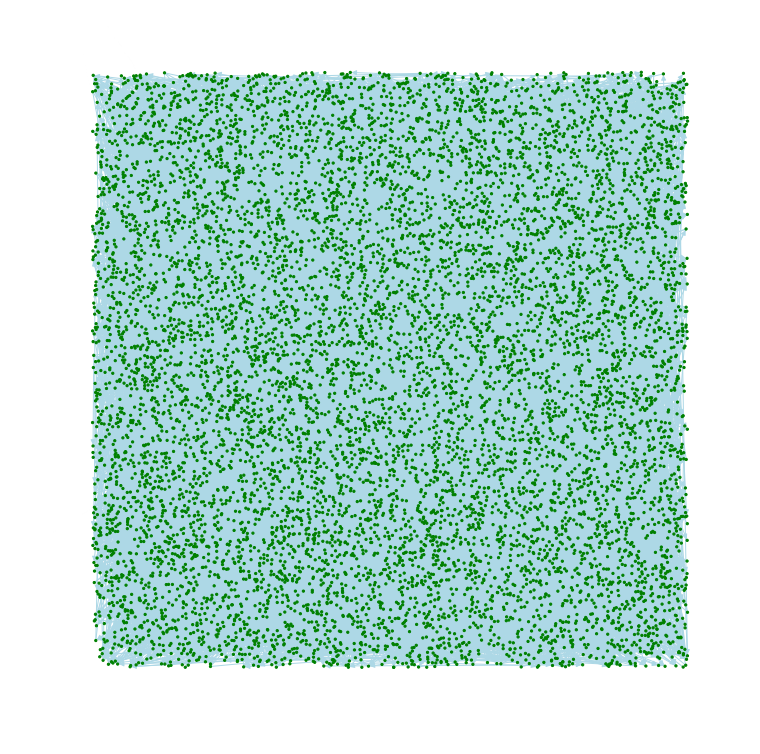

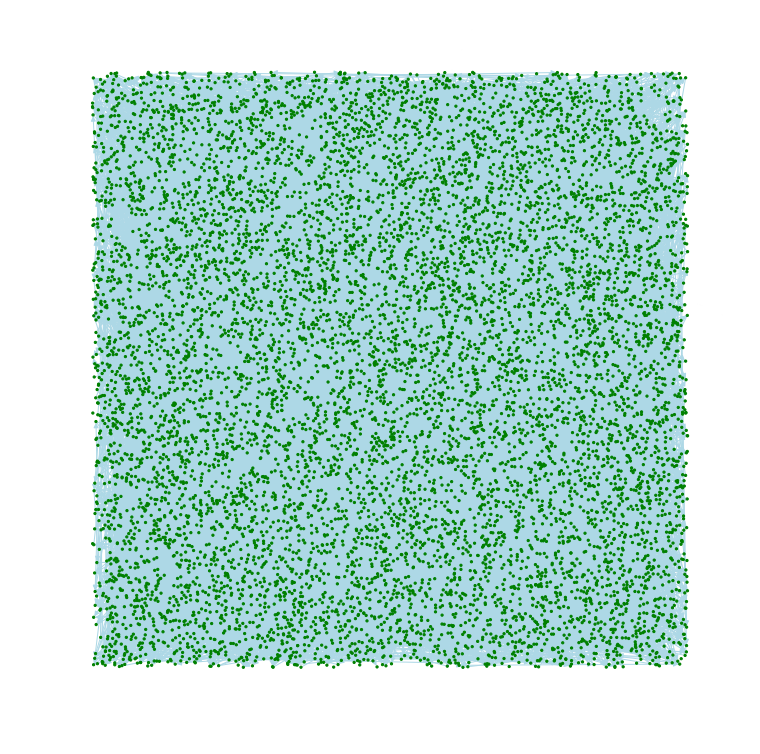

ok

----------------------------------------------------------------------
Ran 1 test in 9754.669s

OK


In [31]:
import unittest
import networkx as nx
import random
import matplotlib.pyplot as plt
import numpy


class Tests(unittest.TestCase):
    
    def test_page_rank_5(self):
        self.graph = nx.DiGraph()
        self.number_of_nodes = random.randint(2, 10000)
        self.nodes = range(self.number_of_nodes)
        self.graph.add_nodes_from(self.nodes)
        for _ in range(2*self.number_of_nodes):
            node_1 = random.choice(list(self.graph.nodes))
            node_2 = random.choice(list(set(self.graph.nodes) - {node_1}))
            if self.graph.has_edge(node_1, node_2) or self.graph.has_edge(node_2, node_1):
                continue
            else:
                weight = random.randint(0, 10)
                self.graph.add_weighted_edges_from([(node_1, node_2, weight)])
        pr = IncrementalPersonalizedPageRank2(self.graph, 0, 500, 0.3)
        pr.initial_random_walks()
        page_ranks = pr.compute_personalized_page_ranks()
        page_ranks_2 = nx.pagerank(pr.graph, alpha=0.7, personalization={0: 1},
                                   max_iter=1000, weight='weight')
        
        node_color = []
        edge_color = []
        for node in self.graph.nodes():
            node_color.append('green')
        for edge in self.graph.edges():
            edge_color.append('lightblue')
        
        plt.figure(figsize=(10, 10))    
        nx.draw_random(pr.graph, node_size=5, edge_width=0.0005, node_color=node_color, edge_color=edge_color)
        plt.show()
    
        diff = numpy.linalg.norm(numpy.array(page_ranks.values()) - numpy.array(page_ranks_2.values())) / \
            numpy.linalg.norm(numpy.array(page_ranks_2.values()))
        self.assertAlmostEqual(diff, 0, delta=0.1)
    
        c = random.randint(self.number_of_nodes//4, self.number_of_nodes//2)
        choices = ["Remove Edge / Add Edge", "Change Edge Weight", "Remove Node / Add Node"]
        for _ in range(c):
            choice = random.choice(choices)
            if choice == "Remove Edge / Add Edge":
                node_1 = random.choice(list(pr.graph.nodes))
                node_2 = random.choice(list(set(pr.graph.nodes) - {node_1}))
                if pr.graph.has_edge(node_1, node_2):
                    pr.remove_edge(node_1, node_2)
                elif pr.graph.has_edge(node_2, node_1):
                    pr.remove_edge(node_2, node_1)
                else:
                    weight = random.randint(-10, 10)
                    pr.add_edge(node_1, node_2, weight)
            elif choice == "Change Edge Weight":
                edge = random.choice(list(pr.graph.edges))
                weight = random.randint(-10, 10)
                pr.add_weight_to_edge(edge[0], edge[1], weight)
            elif choice == "Remove Node / Add Node":
                w = random.randint(0, 1)
                if w == 0:
                    pr.add_node(self.number_of_nodes + 1)
                    self.number_of_nodes += 1
                elif w == 1:
                    node = random.choice(list(set(pr.graph.nodes) - {0}))
                    pr.remove_node(node)
    
        node_color = []
        edge_color = []
        for node in self.graph.nodes():
            node_color.append('green')
        for edge in self.graph.edges():
            edge_color.append('lightblue')
            
        plt.figure(figsize=(10, 10))
        nx.draw_random(pr.graph, node_size=5, edge_width=0.0005, node_color=node_color, edge_color=edge_color)
        plt.show()
        
        pr.update_random_walks()
        new_page_ranks = pr.compute_personalized_page_ranks()
        new_page_ranks_2 = nx.pagerank(pr.graph, alpha=0.7, personalization={0: 1},
                                       max_iter=1000, weight='weight')
        diff = numpy.linalg.norm(numpy.array(new_page_ranks.values()) - numpy.array(new_page_ranks_2.values())) / \
            numpy.linalg.norm(numpy.array(new_page_ranks_2.values()))
        self.assertAlmostEqual(diff, 0, delta=0.1)


unittest.main(argv=[''], verbosity=2, exit=False)

### Convergence Testing <a id="ConvergenceTesting"></a>

We now determine the rate at which the Monte Carlo algorithm converges to its final values for different sets of graphs and input parameters. Again, we randomly generate a graph, with the number of nodes ranging from 2 to 100. We begin with the random generation of the graph. This works analogously to our previous example above in [Test Cases](#TestCases).

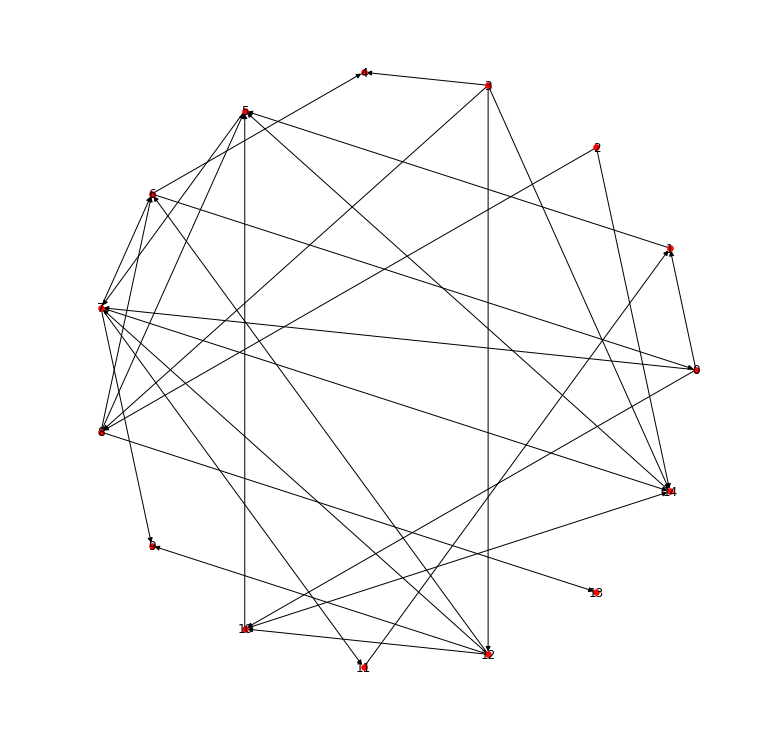

In [26]:
from __future__ import division
import networkx as nx
import random
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import numpy as np

random.seed(1)
graph = nx.DiGraph()
number_of_nodes = random.randint(2, 100)
nodes = range(number_of_nodes)
graph.add_nodes_from(nodes)
number_of_random_walks = 10
random_walk_length = 5
difference = list()

for _ in range(2 * number_of_nodes):
    node_1 = random.choice(list(graph.nodes))
    node_2 = random.choice(list(set(graph.nodes) - {node_1}))
    if graph.has_edge(node_1, node_2) or graph.has_edge(node_2, node_1):
        continue
    else:
        weight = random.randint(0, 10)
        graph.add_weighted_edges_from([(node_1, node_2, weight)])

plt.figure(figsize=(10, 10))
nx.draw_circular(graph, node_size=30, with_labels=True)
plt.show()


Now we determine the values of the Monte Carlo pagerank for reset probabilities $0.1, 0.3$ and $0.5$. We plot the accuracy of the method relative to the power iteration against the number of random walks ranging from 10 to 500. 

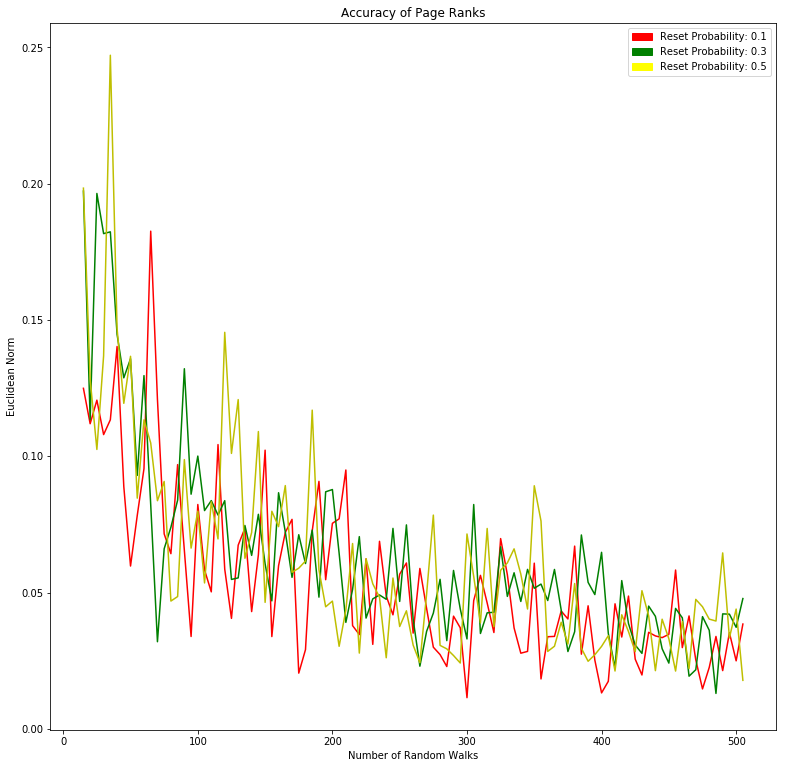

In [29]:
difference = []
reset_probabilities = [0.1, 0.3, 0.5]
for reset_probability in reset_probabilities:
    number_of_random_walks = 10
    while number_of_random_walks <= 500:
        number_of_random_walks += 5
        pr = IncrementalPersonalizedPageRank2(graph, 0, number_of_random_walks, reset_probability)
        pr.initial_random_walks()
        page_ranks = pr.compute_personalized_page_ranks()
        page_ranks_2 = nx.pagerank(pr.graph, alpha=1-reset_probability, personalization={0: 1},
                                   max_iter=500, weight='weight')

        difference.append(np.linalg.norm(np.array(page_ranks.values()) - np.array(page_ranks_2.values())) /
                          np.linalg.norm(page_ranks_2.values()))

plt.figure(figsize=(13, 13))
plt.plot(range(15, 510, 5), difference[0:99], 'r', range(15, 510, 5), difference[99:198], 'g',
         range(15, 510, 5), difference[198:297], 'y')
red_patch = mpatches.Patch(color='red', label='Reset Probability: 0.1')
green_patch = mpatches.Patch(color='green', label='Reset Probability: 0.3')
yellow_patch = mpatches.Patch(color='yellow', label='Reset Probability: 0.5')
# blue_patch = mpatches.Patch(color='blue', label='Reset Probability: 0.3')
# cyan_patch = mpatches.Patch(color='cyan', label='Reset Probability: 0.5')
plt.legend(handles=[red_patch, green_patch, yellow_patch])
plt.title('Accuracy of Page Ranks')
plt.ylabel('Error in % of power iteration values')
plt.ylabel('Euclidean Norm')
plt.xlabel('Number of Random Walks')
plt.show()

The graph above depicts the accuracy of our Monte Carlo computation of the pageranks relative to the power iteration method. We can clearly see a downward trend in the error values over the number of random walks. It is pretty obvious that the Monte Carlo PageRanks become more accurate as the number of random walks through which they are computed, increases. We see that the error values for small numbers of random walks can be as high as $20\%$ and go down to under $5\%$ which are reasonably accurate values as discussed in [Test Cases](#TestCases). We also see that the reset probability has no effect on the accuracy, which is also expected. One should remark the high variance, we can find in these values, as seen in the jaggedness of the curves. This is due to the probabilistic nature of the algorithm, i.e. the random walks. This means the accuracy can vary quite significantly for any number of random walks and any reset probability.

Next, we determine whether the reset probability of the random walks has any impact on the accuracy of the algorithm. We plot three error values of the Monte Carlo method for different numbers of random walks $(10, 100, 300)$. 
 

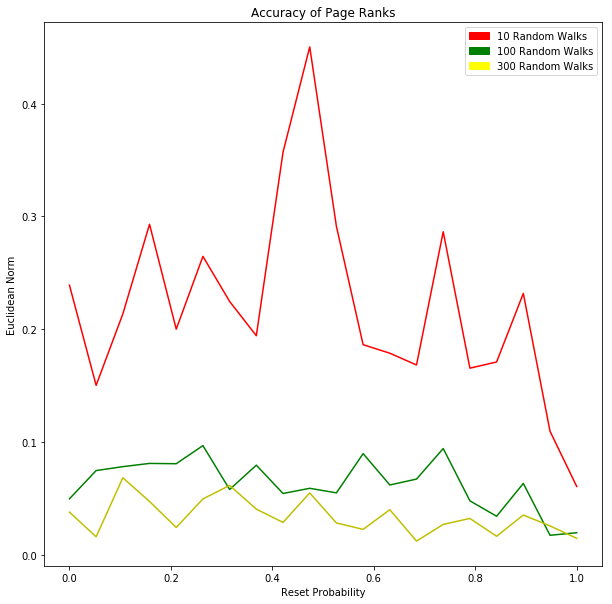

In [31]:
difference = []
numbers_of_random_walks = [10, 100, 300]
for number_of_random_walks in numbers_of_random_walks:
    reset_probability = 0
    while reset_probability <= 1:
        pr = IncrementalPersonalizedPageRank2(graph, 0, number_of_random_walks, reset_probability)
        pr.initial_random_walks()
        page_ranks = pr.compute_personalized_page_ranks()
        page_ranks_2 = nx.pagerank(pr.graph, alpha=1-reset_probability, personalization={0: 1},
                                   max_iter=500, weight='weight')
        difference.append(np.linalg.norm(np.array(page_ranks.values()) - np.array(page_ranks_2.values())) /
                          np.linalg.norm(page_ranks_2.values()))
        reset_probability += 0.05

plt.figure(figsize=(10, 10))
plt.plot(list(np.linspace(0, 1, 20)), difference[0:20], 'r',
         list(np.linspace(0, 1, 20)), difference[20:40], 'g',
         list(np.linspace(0, 1, 20)), difference[40:60], 'y',
         )
red_patch = mpatches.Patch(color='red', label='10 Random Walks')
green_patch = mpatches.Patch(color='green', label='100 Random Walks')
yellow_patch = mpatches.Patch(color='yellow', label='300 Random Walks')
plt.legend(handles=[red_patch, green_patch, yellow_patch])
plt.title('Accuracy of Page Ranks')
plt.ylabel('Euclidean Norm')
plt.xlabel('Reset Probability')
plt.show()

We see in the graph above that the accuracy of the Monte Carlo PageRanks does have a slight dependence on the reset probability as well as the number of random walks. For reset probabilites that are further away from the bounds, 1 and 0, we find that the error values tend to be larger. This makes sense as well. Large reset probabilities generate short random walks, which are less volatile than long ones. Therefore there is less room for probabilistic fluctation, making them more accurate. Analogously, small reset probabilites generate very long random walks that don't reset at all, unless they reach a dangling node. The means the visit times of these random walks are more stable because they cover the entire graph, and therefore we obtain a smaller error. It should also be added that this effect is weakened as the number of random walks increases.

### Sybil Resistance <a id="SybilResistance"></a>

In this section we discuss the properties of sybil resistance of the Monte Carlo method. We randomly generate a graph for an honest region, analogously to the method discussed in [Test Cases](#TestCases). The honest region consists of 500 random nodes and 2000 randomly generated interconnecting edges each weighted from 0 to 10. We also generate a sybil region made up of 1000 nodes which is even more densely connected than the honest region, with 10 edges per node. The honest region is given by the green nodes and light blue edges, while the sybil region has yellow nodes and pink edges. The seed is node 0, is in the honest region.


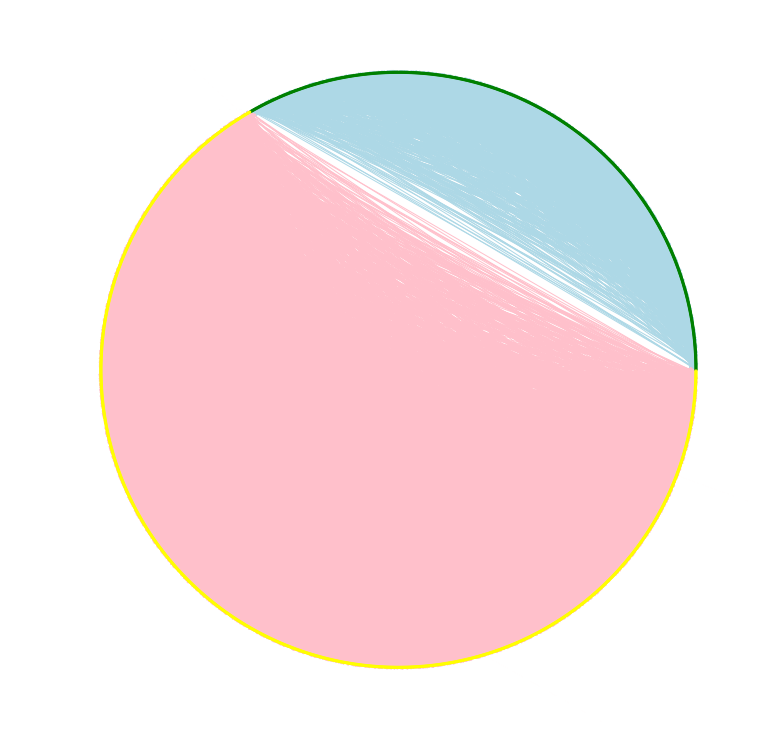

In [4]:
random.seed(135)  # 7
honest_region = nx.DiGraph()
number_of_honest_nodes = 500
honest_nodes = range(number_of_honest_nodes)

honest_region.add_nodes_from(honest_nodes)
for _ in range(4*number_of_honest_nodes):
    node_1 = random.choice(list(honest_region.nodes))
    node_2 = random.choice(list(set(honest_region.nodes) - {node_1}))
    if honest_region.has_edge(node_1, node_2) or honest_region.has_edge(node_2, node_1):
        continue
    else:
        weight = random.randint(1, 10)
        honest_region.add_weighted_edges_from([(node_1, node_2, weight)])

number_of_sybil_nodes = 1000
sybil_region = nx.DiGraph()
sybil_nodes = range(number_of_honest_nodes, number_of_honest_nodes + number_of_sybil_nodes)
sybil_region.add_nodes_from(sybil_nodes)
for _ in range(10*number_of_sybil_nodes):
    node_1 = random.choice(list(sybil_region.nodes))
    node_2 = random.choice(list(set(sybil_region.nodes) - {node_1}))
    if sybil_region.has_edge(node_1, node_2) or sybil_region.has_edge(node_2, node_1):
        continue
    else:
        weight = random.randint(1, 10)
        sybil_region.add_weighted_edges_from([(node_1, node_2, weight)])

node_color = []
for node in honest_region.nodes():
    node_color.append('green')
for node in sybil_region.nodes():
    node_color.append('yellow')
edge_color = []
for edge in honest_region.edges():
    edge_color.append('lightblue')
for edge in sybil_region.edges():
    edge_color.append('pink')

plt.figure(figsize=(10, 10))
initial_graph = nx.compose(honest_region, sybil_region)
nx.draw_shell(initial_graph, node_size=5, edge_width=0.000000000000000000000005, edge_color=edge_color, 
              node_color=node_color) 
plt.show()

Now, we add attack edges connecting the honest and the sybil region in the graph. We compute the Monte Carlo PageRanks of the given graph for every number of attack edges in between 0 and 500. There are several attack edges that are directly connected to the seed node 0. The Monte Carlo algorithm is run with 200 random walks and several different reset probabilities. For each of those pagerank vectors we create a list "ordered_nodes", which orders the nodes in the graph according to their pageranks in a descending order. Using this ordered vector, we determine the [ROC curve](https://acutecaretesting.org/en/articles/roc-curves-what-are-they-and-how-are-they-used) and the area under the ROC curve as a measure of sybil resistance of the Monte Carlo method.

ROC curves are used to show the connection between sensitivity and specificity for every possible cut-off for diagnostic tests. In addition, the area under the ROC curve gives an idea about the benefit of using the test in question. In our case, it is determined as follows. We let the cut-off point run from 1, to the final node. For each, we label the nodes beneath it as sybils and the nodes above as honest. The abscissa of the ROC curve is then given by the false positive rate for each cut-off point and is plotted against the ordinate given by the corresponding true positive rate. We determine the ROC curve for each number of attack edges and a set of different reset probabilities (0.1, 0.3, 0.5, 0.7). 

Next, we determine the area under the ROC curve for every ROC curve computed. The area under the ROC curve (AUROC) of a test can be used as a criterion to measure the test's discriminative ability. We obtain the following graphs. 

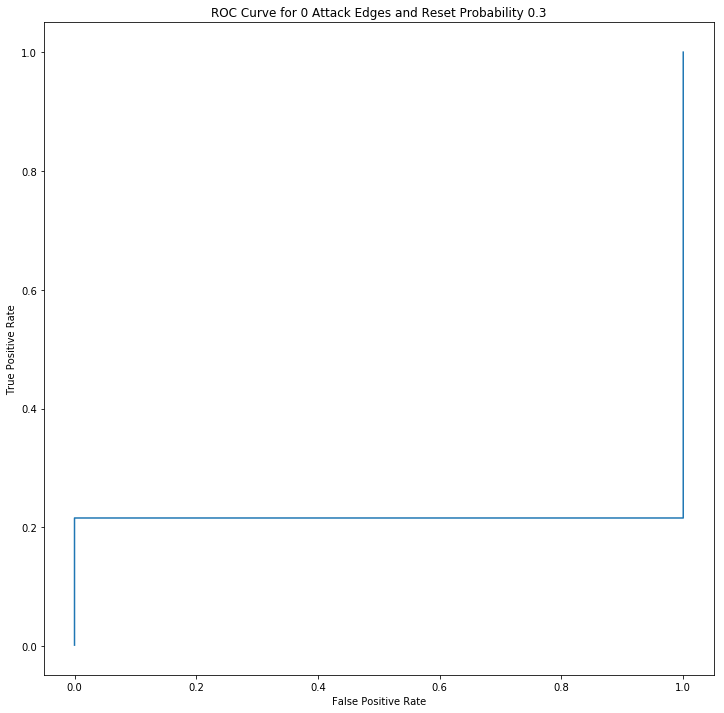

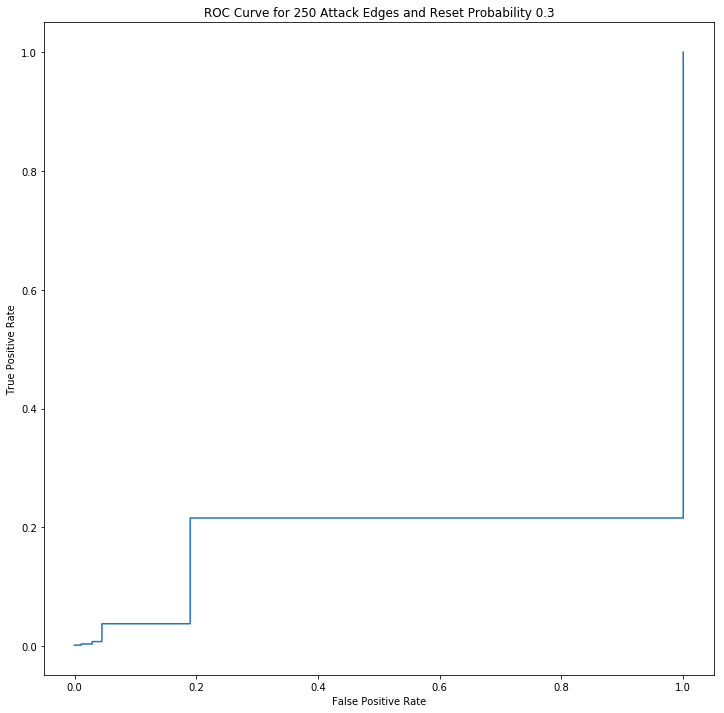

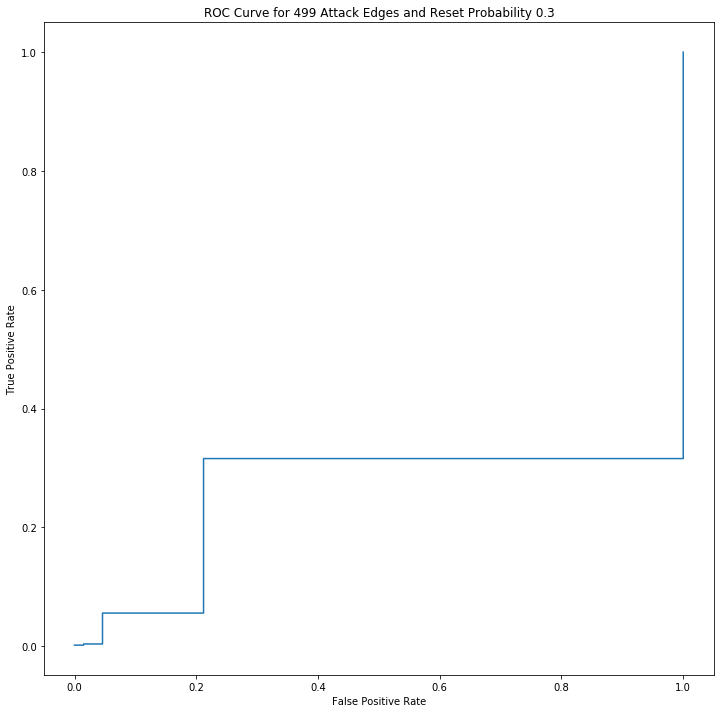

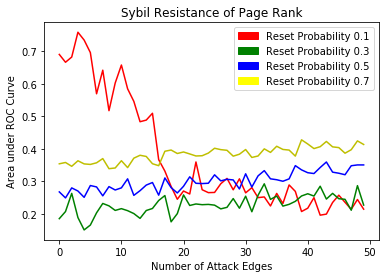

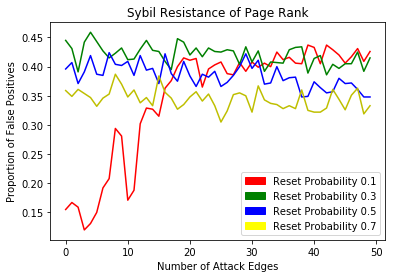

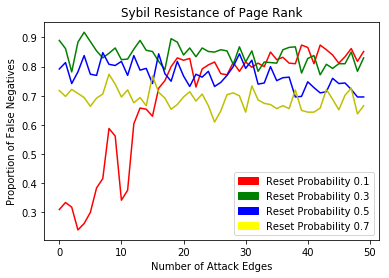

In [5]:
from __future__ import division
import networkx as nx
import matplotlib.pyplot as plt
import random
import numpy as np
from Page_Rank2 import IncrementalPersonalizedPageRank2
import matplotlib.patches as mpatches
import copy

random.seed(135)  # 7
reset_probabilities = [0.1, 0.3, 0.5, 0.7]
area_ROC = []
false_positives = []
false_negatives = []
for reset_probability in reset_probabilities:
    graph = copy.deepcopy(initial_graph)
    for number_of_attack_edges in range(500):
        for _ in range(number_of_attack_edges):
            honest_node = random.choice(list(honest_region.nodes()))
            sybil_node = random.choice(list(sybil_region.nodes()))

            r = random.uniform(0, 1)
            if r < 0.5:
                graph.add_weighted_edges_from([(honest_node, sybil_node, random.randint(1, 10))])
            else:
                graph.add_weighted_edges_from([(sybil_node, honest_node, random.randint(1, 10))])
        
        pr = IncrementalPersonalizedPageRank2(graph, 0, 200, reset_probability)
        pr.initial_random_walks()
        page_ranks = pr.compute_personalized_page_ranks()
        page_ranks_list = sorted(page_ranks.iteritems(), key=lambda (k, v): (v, k), reverse=True)
        ordered_nodes = list(zip(*page_ranks_list)[0])

        ROC_abscissa = []
        ROC_ordinate = []
        for i in range(1, len(graph.nodes())+1):
            positives = ordered_nodes[:i]  # Non Sybils
            negatives = ordered_nodes[i:]  # Sybils
            ROC_abscissa.append(len(set(positives).intersection(set(sybil_region.nodes()))) / len(sybil_region.nodes()))
            ROC_ordinate.append(len(set(positives).intersection(set(honest_region.nodes()))) / len(honest_region.nodes()))

        if number_of_attack_edges in [0, 250, 499] and reset_probability == 0.3:
            plt.figure(figsize=(12, 12))
            plt.plot(ROC_abscissa, ROC_ordinate)
            plt.title("ROC Curve for " + str(number_of_attack_edges) + " Attack Edges and Reset Probability " + 
                      str(reset_probability ))
            plt.xlabel("False Positive Rate")
            plt.ylabel("True Positive Rate")
            plt.show()
            
        area_ROC.append(np.trapz(ROC_ordinate, ROC_abscissa))
        false_positives.append(len(list(set(ordered_nodes[:number_of_honest_nodes]).intersection(set(sybil_nodes)))) / number_of_sybil_nodes)
        false_negatives.append(len(list(set(ordered_nodes[number_of_honest_nodes:]).intersection(set(honest_nodes)))) / number_of_honest_nodes)


plt.plot(range(50), area_ROC[:50], 'r',
         range(50), area_ROC[50:100], 'g',
         range(50), area_ROC[100:150], 'b',
         range(50), area_ROC[150:200], 'y')
red_patch = mpatches.Patch(color='red', label='Reset Probability 0.1')
green_patch = mpatches.Patch(color='green', label='Reset Probability 0.3')
blue_patch = mpatches.Patch(color='blue', label='Reset Probability 0.5')
yellow_patch = mpatches.Patch(color='yellow', label='Reset Probability 0.7')
plt.legend(handles=[red_patch, green_patch, blue_patch, yellow_patch])
plt.xlabel("Number of Attack Edges")
plt.ylabel("Area under ROC Curve")
plt.title("Sybil Resistance of Page Rank")
plt.show()
plt.plot(range(50), false_positives[:50], 'r',
         range(50), false_positives[50:100], 'g',
         range(50), false_positives[100:150], 'b',
         range(50), false_positives[150:200], 'y')
red_patch = mpatches.Patch(color='red', label='Reset Probability 0.1')
green_patch = mpatches.Patch(color='green', label='Reset Probability 0.3')
blue_patch = mpatches.Patch(color='blue', label='Reset Probability 0.5')
yellow_patch = mpatches.Patch(color='yellow', label='Reset Probability 0.7')
plt.legend(handles=[red_patch, green_patch, blue_patch, yellow_patch])
plt.xlabel("Number of Attack Edges")
plt.ylabel("Proportion of False Positives")
plt.title("Sybil Resistance of Page Rank")
plt.show()
plt.plot(range(50), false_negatives[:50], 'r',
         range(50), false_negatives[50:100], 'g',
         range(50), false_negatives[100:150], 'b',
         range(50), false_negatives[150:200], 'y')
red_patch = mpatches.Patch(color='red', label='Reset Probability 0.1')
green_patch = mpatches.Patch(color='green', label='Reset Probability 0.3')
blue_patch = mpatches.Patch(color='blue', label='Reset Probability 0.5')
yellow_patch = mpatches.Patch(color='yellow', label='Reset Probability 0.7')
plt.legend(handles=[red_patch, green_patch, blue_patch, yellow_patch])
plt.xlabel("Number of Attack Edges")
plt.ylabel("Proportion of False Negatives")
plt.title("Sybil Resistance of Page Rank")
plt.show()


We can see in the plots above that the area under the ROC curve decreases monotonely for random walks with reset probability 0.1. This does not hold for shorter random walks. When we think about this, we find that it makes perfect sense. Given the size of the graph and the length of the random walks, most nodes in the honest network are never visited by any random walk. Hence they have a pagerank of 0. This means they are at the bottom of the ordered_nodes vector and therefore labelled a sybil for almost all cut-off points, i.e. we have a very large proportion of false negatives. This does not hold for the random walks with reset probability 
of 0.1, because those random walks travers the entire graph. This leads to a slightly misleading conclusion.

Overall, we get a false positives rate of in between 0.35 and 0.45. The shorter the random walks, the lower this rate. We also find that that for short random walks this rate actually decreases with the number of attack edges. This is because a larger number of attack edges enables random walks that have entered the Sybil region, to also escape it. 

In order to obtain results that are more representative of the method's sybil resistance, we remove all nodes with pageranks of exactly 0 from the ordered_nodes vector. With this, we obtain the following results.

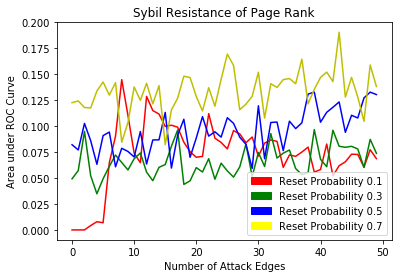

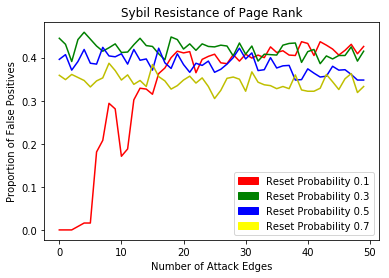

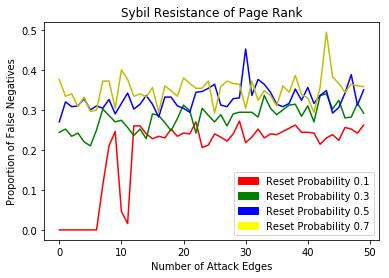

In [33]:
from __future__ import division
import networkx as nx
import matplotlib.pyplot as plt
import random
import numpy as np
from Page_Rank2 import IncrementalPersonalizedPageRank2
import matplotlib.patches as mpatches
import copy

random.seed(135)  # 7
reset_probabilities = [0.1, 0.3, 0.5, 0.7]
area_ROC = []
false_positives = []
false_negatives = []
for reset_probability in reset_probabilities:
    graph = copy.deepcopy(initial_graph)
    for number_of_attack_edges in range(500):
        for _ in range(number_of_attack_edges):
            honest_node = random.choice(list(honest_region.nodes()))
            sybil_node = random.choice(list(sybil_region.nodes()))

            r = random.uniform(0, 1)
            if r < 0.5:
                graph.add_weighted_edges_from([(honest_node, sybil_node, random.randint(1, 10))])
            else:
                graph.add_weighted_edges_from([(sybil_node, honest_node, random.randint(1, 10))])

        pr = IncrementalPersonalizedPageRank2(graph, 0, 200, reset_probability)
        pr.initial_random_walks()
        page_ranks = pr.compute_personalized_page_ranks()
        truncated_page_ranks = {k: v for k, v in page_ranks.items() if v != 0}
        page_ranks_list = sorted(truncated_page_ranks.iteritems(), key=lambda (k, v): (v, k), reverse=True)
        ordered_nodes = list(zip(*page_ranks_list)[0])

        ROC_abscissa = []
        ROC_ordinate = []
        for i in range(1, len(ordered_nodes)+1):
            positives = ordered_nodes[:i]  # Non Sybils
            negatives = ordered_nodes[i:]  # Sybils
            ROC_abscissa.append(len(set(positives).intersection(set(sybil_region.nodes()))) / len(sybil_region.nodes()))
            ROC_ordinate.append(len(set(positives).intersection(set(honest_region.nodes()))) / len(honest_region.nodes()))

        # plt.plot(ROC_abscissa, ROC_ordinate)
        # plt.show()

        area_ROC.append(np.trapz(ROC_ordinate, ROC_abscissa))
        false_positives.append(len(list(set(ordered_nodes[:number_of_honest_nodes]).intersection(set(sybil_nodes)))) /
                               number_of_sybil_nodes)
        false_negatives.append(len(list(set(ordered_nodes[number_of_honest_nodes:]).intersection(set(honest_nodes)))) /
                               number_of_honest_nodes)


plt.plot(range(50), area_ROC[:50], 'r',
         range(50), area_ROC[50:100], 'g',
         range(50), area_ROC[100:150], 'b',
         range(50), area_ROC[150:200], 'y')
red_patch = mpatches.Patch(color='red', label='Reset Probability 0.1')
green_patch = mpatches.Patch(color='green', label='Reset Probability 0.3')
blue_patch = mpatches.Patch(color='blue', label='Reset Probability 0.5')
yellow_patch = mpatches.Patch(color='yellow', label='Reset Probability 0.7')
plt.legend(handles=[red_patch, green_patch, blue_patch, yellow_patch])
plt.xlabel("Number of Attack Edges")
plt.ylabel("Area under ROC Curve")
plt.title("Sybil Resistance of Page Rank")
plt.show()

plt.plot(range(50), false_positives[:50], 'r',
         range(50), false_positives[50:100], 'g',
         range(50), false_positives[100:150], 'b',
         range(50), false_positives[150:200], 'y')
red_patch = mpatches.Patch(color='red', label='Reset Probability 0.1')
green_patch = mpatches.Patch(color='green', label='Reset Probability 0.3')
blue_patch = mpatches.Patch(color='blue', label='Reset Probability 0.5')
yellow_patch = mpatches.Patch(color='yellow', label='Reset Probability 0.7')
plt.legend(handles=[red_patch, green_patch, blue_patch, yellow_patch])
plt.xlabel("Number of Attack Edges")
plt.ylabel("Proportion of False Positives")
plt.title("Sybil Resistance of Page Rank")
plt.show()

plt.plot(range(50), false_negatives[:50], 'r',
         range(50), false_negatives[50:100], 'g',
         range(50), false_negatives[100:150], 'b',
         range(50), false_negatives[150:200], 'y')
red_patch = mpatches.Patch(color='red', label='Reset Probability 0.1')
green_patch = mpatches.Patch(color='green', label='Reset Probability 0.3')
blue_patch = mpatches.Patch(color='blue', label='Reset Probability 0.5')
yellow_patch = mpatches.Patch(color='yellow', label='Reset Probability 0.7')
plt.legend(handles=[red_patch, green_patch, blue_patch, yellow_patch])
plt.xlabel("Number of Attack Edges")
plt.ylabel("Proportion of False Negatives")
plt.title("Sybil Resistance of Page Rank")
plt.show()

* Are under the ROC Curve    
We find that the area under the ROC curve increases quite significantly after the 5th attack edge is added. This is because the 5th attack edge is the first attack edge that is directly connected to the seed node. Therafter it decreases moderately with the number of attack edges. For the remaining reset probabilities this does not seem to be the case. Instead the area under the ROC curve increases with the number of attack edges connecting the sybil and the honest region. This is due to the reasons we discussed above. 

* False Positives   
False positives are sybil nodes that are considered honest according to their pageranks. We find that for the reset probability of 0.1 the number of false positives increases abruptly after the 5th attack edge is added, again for the same reasons as mentioned above. The remaining reset probabilities exhibit rather constant numbers of false positives. The overall average of false positives for the algorithm in this network lies at around $35\%$.

* False Negatives   
False negatives are honest nodes that are marked as sybils by the algorithm. We find again that the monte carlo algorithm with a reset probability of 0.1 exhibits a jump in false negatives at around 5 attack edges. The remaining pagerank values seem to be quite constant with a minor upward trend with the number of attack edges added. The overall average here is at around $30\%$. 

We find that these values are not really satisfactory and that therefore the Monte Carlo PageRank algorithm is not praticularly sybil resistant. This makes sense to us. Random walk based page rank algorithms are rarely sybil resistant, simply due to the random walks that they are based on. It is easy for a random walk to end up in the sybil region and there is no mechanism to prevent this in our current implementation. In the future we may want to implement a mechanism to enhance our algorithms sybil proofness. 


# Application to the Tribler Network <a id="TriblerApplication"></a>
We now apply our implementation of the Monte Carlo algorithm to the Tribler network.
### Generating the Graph
First we generate a graph of the Tribler network. We generate the graph using the class GraphReduction2, as discussed in [Monte Carlo Methods for PageRank approximation](#MonteCarlo). There are 667124 blocks in our [data set](http://explorer.tribler.org/trustchain.db). This corresponds to a graph of 289 nodes. We first create our graph for all but 5 nodes and all but 20 edges. Then we compute the corresponding PageRanks. We update the graph by adding the missing nodes and edges and to the graph. Then we update our random walks and recompute the PageRank values. In both cases we compare our values with the Power Iteration values and time the entire process. We employ our monte carlo algorithm with 300 random walks and a reset probability of 0.3.

### Computing the PageRank Values <a id="TriblerPageRanks"></a>

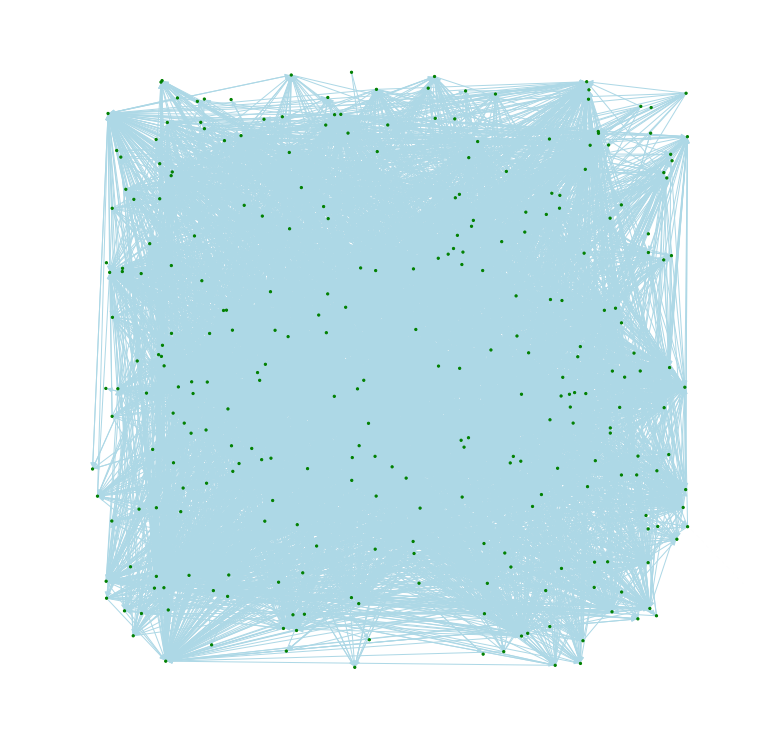

In [37]:
"""
The code below opens the trustchain data set and and runs the Monte Carlo page rank algorithm on a graph generated
from all transactions blocks, where nodes correspond to peers and edge weights to net flows of data in between peers.
The execution of the entire code takes roughly 120 seconds. Loading the data set only needs to be done once. Thereafter
the page ranks are computed incrementally upon changes in the graph.
"""
import networkx as nx
import matplotlib.pyplot as plt

file_path = "C:\\Users\\alexa\\Documents\\TU Delft\\Course material\\Other\\Blockchain\\Blockchain Lab\\Incremental Pagerank\\"
file_name = "trustchain"

gr = GraphReduction2(file_path, file_name)
gr.open_data_set()
graph = gr.graph
nodes = list(gr.nodes)
edges = list(gr.edges)

graph.add_nodes_from(nodes[:-5])
edges_to_add = []

for edge in edges:
    if edge[0] in graph.nodes() and edge[1] in graph.nodes():
        graph.add_weighted_edges_from([edge])
    else:
        edges_to_add.append(edge)

node_color = []
edge_color = []

for node in graph.nodes():
    node_color.append('green')
for edge in graph.edges():
    edge_color.append('lightblue')

plt.figure(figsize=(10, 10))
nx.draw_random(graph, node_size=5, edge_width=0.00001, edge_color=edge_color, node_color=node_color)
plt.show()

In [38]:
import time
import numpy as np

random.seed(7)  # 13, 7
start_time = time.time()
seed_node = random.choice(gr.nodes)
pr = IncrementalPersonalizedPageRank2(graph, seed_node, 100000, 0.3)
pr.initial_random_walks()
page_ranks = pr.compute_personalized_page_ranks()
page_ranks_2 = nx.pagerank(graph, alpha=0.7, personalization={seed_node: 1},
                           max_iter=500, weight='weight')
finish_time = time.time()
print finish_time - start_time, " Seconds"

print "MC: ", page_ranks.values()
print "PI: ", page_ranks_2.values()
print "Error Value (Euclidean Norm): ", np.linalg.norm(np.array(page_ranks.values()) - np.array(page_ranks_2.values())) / \
      np.linalg.norm(page_ranks.values()) 
print "Error Value (Supremum Nom): ", np.max(np.array(page_ranks.values()) - np.array(page_ranks_2.values())) / \
                                      np.max(page_ranks_2.values())  



14.1710000038  Seconds
MC:  [0.0, 0.06407894776381781, 5.1085261301111556e-05, 0.0, 0.0, 0.00043873224411542866, 0.17791494003491828, 0.0, 3.005015370653621e-05, 0.0, 0.0, 0.0, 0.0, 1.2020061482614483e-05, 0.0, 0.0, 0.0, 1.5025076853268105e-05, 2.4040122965228965e-05, 0.0, 0.0, 0.0, 0.0, 0.0, 3.0050153706536207e-06, 6.310532278372604e-05, 0.0, 0.0, 2.4040122965228965e-05, 0.0, 0.0, 3.606018444784345e-05, 3.0050153706536207e-06, 0.0, 0.0, 0.01449919916340372, 0.00013823070705006656, 0.02312960330792092, 4.507523055980431e-05, 0.0, 0.0, 0.047767724331909955, 0.0, 0.0, 6.911535352503328e-05, 0.0001863109529805245, 3.005015370653621e-05, 2.7045138335882587e-05, 0.0, 0.0, 0.0, 0.00010217052260222311, 0.0, 7.512538426634052e-05, 0.0004958275361578474, 0.0, 8.113541500764777e-05, 5.4090276671765175e-05, 0.0, 0.0, 0.00015025076853268104, 0.0, 0.0, 3.0050153706536207e-06, 0.0, 0.0, 0.0, 0.00016227083001529554, 0.0005559278435709198, 0.0002734563987294795, 0.0, 0.0, 0.0, 0.0, 0.0, 3.005015370653

We obtain a vector of pageranks in 17 seconds. The monte carlo pageranks have an accuracy of $39\%$ in the euclidean norm and $14\%$ in the supremum norm. This is not quire as accurate as our previous results for smaller graphs and we note that there must be some scalability issues in the algorithm. 

### Incremental Updates <a id="IncrementalUpdates"></a>

Now, we update our graph by adding the missing edges and nodes. We recompute the Power Iteration PageRanks as before, but recompute the Monte Carlo PageRanks not from scratch, but by updating the necessary random walks, as discussed in [Monte Carlo Methods for PageRank approximation](#MonteCarlo).

In [39]:
import networkx as nx
import matplotlib.pyplot as plt

start_time = time.time()
for node in nodes[-5:]:
    pr.add_node(node)

for edge in edges_to_add:
    pr.add_edge(edge[0], edge[1], edge[2])
    
pr.update_random_walks()
new_page_ranks = pr.compute_personalized_page_ranks()
new_page_ranks_2 = nx.pagerank(pr.graph, alpha=0.7, personalization={seed_node: 1},
                               max_iter=500, weight='weight')

finish_time = time.time()
print finish_time - start_time, " Seconds"

print "MC: ", new_page_ranks.values()
print "PI: ", new_page_ranks_2.values()
print "Error Value (Euclidean Norm): ", np.linalg.norm(np.array(new_page_ranks.values()) - np.array(new_page_ranks_2.values())) / \
      np.linalg.norm(new_page_ranks.values())
print "Error Value (Supremum Nom): ", np.max(np.array(new_page_ranks.values()) - np.array(new_page_ranks_2.values())) / \
                                      np.max(new_page_ranks_2.values())




5.17000007629  Seconds
MC:  [0.0, 0.0640680909361302, 5.107421082833357e-05, 0.0, 0.0, 0.0004746897241692179, 0.17792752869919995, 0.0, 3.304801877127466e-05, 0.0, 0.0, 0.0, 0.0, 1.2017461371372605e-05, 0.0, 0.0, 0.0, 1.8026192057058906e-05, 2.403492274274521e-05, 0.0, 6.0087306856863025e-06, 0.0, 0.0, 0.0, 0.0, 6.309167219970617e-05, 0.0, 0.0, 2.403492274274521e-05, 0.0, 0.0, 3.605238411411781e-05, 0.0, 0.0, 0.0, 0.014466019125789773, 0.0001412051711136281, 0.023118591313178047, 3.605238411411781e-05, 0.0, 0.0, 0.047751382759149044, 0.0, 0.0, 6.609603754254932e-05, 0.00018627065125627538, 3.004365342843151e-05, 2.703928808558836e-05, 0.0, 0.0, 0.0, 0.00010214842165666714, 0.0, 7.210476822823562e-05, 0.0004897115508834336, 0.0, 8.111786425676507e-05, 4.206111479980411e-05, 0.0, 0.0, 0.00015021826714215755, 0.0, 0.0, 3.0043653428431513e-06, 0.0, 0.0, 0.0, 0.00016223572851353015, 0.0005648206844545124, 0.00027339724619872675, 0.0, 0.0, 0.0, 0.0, 0.0, 6.0087306856863025e-06, 0.0, 0.0, 0.0

We find that the computation time of the updates lies at roughly 5 seconds. This is a satisfactory result. The newly computed accuracy of the incremental Monte Carlo method now lied at $46\%$ for the euclidean norm and $20\%$ for the supremum norm. These values are slightly larger than the ones we obtained from the initial computation, but still reasonable. 

# Conclusion <a id="TriblerPageRanks"></a>

In this project, we implemented an incremental personalized PageRank algorithm for ranking nodes in a peer-to-peer file sharing network, called Tribler using the Monte Carlo method. We chose algorithm 4 from [Avrachenkov, Konstantin, et al.](https://scholar.google.nl/scholar?hl=nl&as_sdt=0%2C5&q=Monte+Carlo+methods+in+PageRank+computation%3A+When+one+iteration+is+su%EF%AC%83cient&btnG=), with a set of standard random walks on a directed graph with weighted edges. The graph of the tribler network was generated by "flattening" the blockchain's blocks into a unidirectional graph with edge weights corresponding to the net data flow in between nodes. 

We found that for relatively small graphs, the algorithm is quite fast (14 seconds for the initial computation and 5 seconds for the incremental updates). We find however that the error values tend to increase with the size of the network and for the initial computation of the pageranks of the tribler network we obtain an error of almost $40\%$ and $47\%$ for the incremental updates. One should note here that the application of the PageRanks is primarily to rank nodes based on their trustworthiness in order to select the most trusted nodes to interact with. This means, the PageRanks of lower-ranked nodes are not as relevant as the PageRanks of the highly-ranked nodes. Therefore the algorithm is still applicable and returns useful results for the tribler application. 

We inspected the rate of convergence of the algorithm and found that the accuracy of values, relative to the power iteration's values improves exponentially by the number of random walks and shrink down to values close to $3\%$ for a network consisting of 15 nodes. As the network grows these values increase as well. This is due to small inaccuracies accumulating by the iterations and thereby growing to ever larger values. We suspect that choosing the networkx library's approximation of PageRanks using the power iteration may not have been the best relative reference for our pagerank. An example illustrates the possible inaccuracy of the Power Iteration's values. If we choose a network with an isolated seed node then we expect a PageRank vector consisting only of zeros and a single value of one. However the power iteration returns many very small values for nodes other than the seed node.







C:\Users\alexa\Anaconda2\lib\site-packages\networkx\drawing\layout.py:610: RuntimeWarning: divide by zero encountered in true_divide
  costargs = (np, 1 / (dist_mtx + np.eye(dist_mtx.shape[0]) * 1e-3),


C:\Users\alexa\Anaconda2\lib\site-packages\networkx\drawing\layout.py:635: RuntimeWarning: invalid value encountered in subtract
  np.einsum('ij,ij,ijk->jk', invdist, offset, direction))


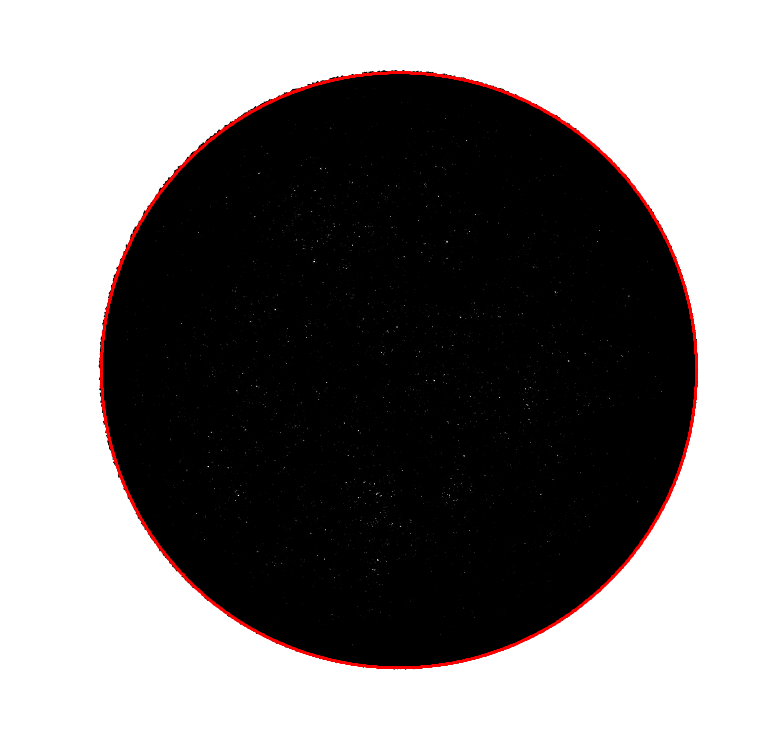

Monte Carlo Values:
{0: 1.0, 1: 0.0, 2: 0.0, 3: 0.0, 4: 0.0, 5: 0.0, 6: 0.0, 7: 0.0, 8: 0.0, 9: 0.0, 10: 0.0, 11: 0.0, 12: 0.0, 13: 0.0, 14: 0.0, 15: 0.0, 16: 0.0, 17: 0.0, 18: 0.0, 19: 0.0, 20: 0.0, 21: 0.0, 22: 0.0, 23: 0.0, 24: 0.0, 25: 0.0, 26: 0.0, 27: 0.0, 28: 0.0, 29: 0.0, 30: 0.0, 31: 0.0, 32: 0.0, 33: 0.0, 34: 0.0, 35: 0.0, 36: 0.0, 37: 0.0, 38: 0.0, 39: 0.0, 40: 0.0, 41: 0.0, 42: 0.0, 43: 0.0, 44: 0.0, 45: 0.0, 46: 0.0, 47: 0.0, 48: 0.0, 49: 0.0, 50: 0.0, 51: 0.0, 52: 0.0, 53: 0.0, 54: 0.0, 55: 0.0, 56: 0.0, 57: 0.0, 58: 0.0, 59: 0.0, 60: 0.0, 61: 0.0, 62: 0.0, 63: 0.0, 64: 0.0, 65: 0.0, 66: 0.0, 67: 0.0, 68: 0.0, 69: 0.0, 70: 0.0, 71: 0.0, 72: 0.0, 73: 0.0, 74: 0.0, 75: 0.0, 76: 0.0, 77: 0.0, 78: 0.0, 79: 0.0, 80: 0.0, 81: 0.0, 82: 0.0, 83: 0.0, 84: 0.0, 85: 0.0, 86: 0.0, 87: 0.0, 88: 0.0, 89: 0.0, 90: 0.0, 91: 0.0, 92: 0.0, 93: 0.0, 94: 0.0, 95: 0.0, 96: 0.0, 97: 0.0, 98: 0.0, 99: 0.0, 100: 0.0, 101: 0.0, 102: 0.0, 103: 0.0, 104: 0.0, 105: 0.0, 106: 0.0, 107: 0.0, 108: 0.0,

In [27]:
import networkx as nx
import numpy as np
import random

random.seed(3)
graph = nx.DiGraph()
number_of_nodes = random.randint(2, 10000)
nodes = range(number_of_nodes)
graph.add_nodes_from(nodes)
for _ in range(2*number_of_nodes):
    node_1 = random.choice(list(graph.nodes))
    node_2 = random.choice(list(set(graph.nodes) - {node_1}))
    if graph.has_edge(node_1, node_2) or graph.has_edge(node_2, node_1) or node_1 == 0 or node_2 == 0:
        continue
    else:
        weight = random.randint(0, 10)
        graph.add_weighted_edges_from([(node_1, node_2, weight)])
pr = IncrementalPersonalizedPageRank2(graph, 0, 500, 0.3)
pr.initial_random_walks()
MC = pr.compute_personalized_page_ranks()
PI = page_ranks_2 = nx.pagerank(pr.graph, alpha=0.7, personalization={0: 1},
                                max_iter=500, weight='weight')

plt.figure(figsize=(10, 10))
nx.draw_kamada_kawai(graph, node_size=3, edge_width=0.0005)
plt.show()
print "Monte Carlo Values:\n", MC, "\n"
print "Power Iteration Values:\n", PI, "\n"
print "Error Value (Euclidean Norm):\n", np.linalg.norm(np.array(MC.values()) - np.array(PI.values())) / \
      np.linalg.norm(PI.values()), "%\n"
print "Error Value (Supremum Norm):\n", np.max(np.array(MC.values()) - np.array(PI.values())) / \
                                      np.max(PI.values()), "%" 




This reveals an inherent inaccuracy of the Power Iteration's PageRank values which may have distorted the validity of our results for the Monte Carlo PageRanks. This is something we may look into in the future.

Finally, we tested the algorithm for its sybil resistance. We generated an honest region and a sybil region connected by a varying number of attack edges. We found that for an honest region with 500 nodes and a sybil region of 1000 nodes and a number of attack edges increasing up to 500 edges the algorithm exhibited a rather large percentage of false positives and negatives and a relatively low ROC curve. This was to be expected, simply due to the random walk based nature of the algorithm. In future work we may look into optimizing this algorithm to account for sybil attacks.

# Future Work <a id="FutureWork"></a>

We will continue to improve and optimize this algorithm in the future. Among the many more things we will look into and refine are:

* No CPU hogging
* Churn (what to do about offline nodes)
* What to do about relay nodes?
* Possibly improve accuracy
* Make updates continuous, i.e. allow graph changes to update the page ranks in real time, by directly loading changes made to the data base.
* Change graph structure to bidirectional to take into account absolute up and download values
